In [104]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
from sklearn.multioutput import MultiOutputClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from tqdm import tqdm
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW

In [88]:
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, model, max_length=512):
        self.texts = texts
        self.labels = labels
        self.model = model
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        
        # Tokenize the text using the model's tokenizer
        encoding = self.model._first_module().tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [89]:
# Reuse the prepare_data and plot_multilabel_confusion_matrix functions from the previous file
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{args.text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels


In [90]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.suptitle(f'Confusion Matrices for {model_name}')
    plt.tight_layout()
    return fig


In [91]:
def get_embeddings(texts, model, batch_size=32):
    """
    Get SBERT embeddings for a list of texts in batches.
    """
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size].tolist()
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)


In [92]:
def get_embeddings(texts, model, batch_size=32):
    """
    Get SBERT embeddings for a list of texts in batches.
    """
    model.eval()
    embeddings = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch_texts = texts[i:i + batch_size].tolist()
            
            # Tokenize the batch
            encoding = model._first_module().tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )
            
            # Move to device
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get embeddings
            outputs = model._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            
            # Store embeddings
            embeddings.append(pooled_output.cpu().numpy())
    
    return np.vstack(embeddings)

In [93]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate all relevant metrics for multi-label classification.
    """
    exact_match = (y_pred == y_true).all(axis=1).mean()
    
    # Calculate partial match accuracy
    true_positives = np.logical_and(y_pred == 1, y_true == 1).sum(axis=1)
    total_positives = (y_true == 1).sum(axis=1)
    partial_match = np.zeros_like(true_positives, dtype=float)
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # Calculate Jaccard similarity
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        result = np.zeros_like(intersection, dtype=float)
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(y_true, y_pred)
    
    # Calculate sample-based metrics
    precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
    recall = recall_score(y_true, y_pred, average='samples', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
    
    return {
        'exact_match': float(exact_match),
        'partial_match': float(partial_match_accuracy),
        'jaccard': float(jaccard_sim),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }


In [94]:
def train_and_evaluate_model(model, train_embeddings, train_labels, val_embeddings, val_labels, model_name, run_dir, mlb):
    """
    Train and evaluate a single model, saving results and visualizations.
    """
    print(f"\nTraining {model_name}...")
    model.fit(train_embeddings, train_labels)
    
    print(f"Making predictions with {model_name}...")
    val_preds = model.predict(val_embeddings)
    
    # Calculate metrics
    metrics = calculate_metrics(val_labels, val_preds)
    
    # Print metrics
    print(f"\n{model_name} Validation Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot and save confusion matrices
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        val_labels[:, :num_labels_to_plot], 
        val_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot],
        model_name
    )
    plt.savefig(os.path.join(run_dir, f'confusion_matrices_{model_name.lower().replace(" ", "_")}.png'))
    
    # If it's Random Forest, save feature importances
    if isinstance(model, RandomForestClassifier):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(feature_importances)), feature_importances)
        plt.title(f'Feature Importances for {model_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.savefig(os.path.join(run_dir, f'feature_importances_{model_name.lower().replace(" ", "_")}.png'))
    
    return metrics


In [95]:
def train_sbert_epoch(model, train_loader, criterion, optimizer, device, gradient_accumulation_steps=4):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    optimizer.zero_grad()
    
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        # Gradient accumulation
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        predictions = torch.sigmoid(outputs) >= 0.5
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
        
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Handle remaining gradients
    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate metrics
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return total_loss / len(train_loader), exact_match, precision, recall, f1


In [96]:
def validate_sbert(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            predictions = torch.sigmoid(outputs) >= 0.5
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
            # Clear GPU cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate metrics
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return total_loss / len(val_loader), exact_match, precision, recall, f1


In [97]:
class FineTunedSBERT(SentenceTransformer):
    """
    A fine-tunable version of SBERT that unfreezes the last 3 layers.
    """
    def __init__(self, model_name='all-mpnet-base-v2', num_labels=20):
        super().__init__(model_name)
        # Freeze all parameters first
        for param in self.parameters():
            param.requires_grad = False
        
        # Unfreeze the last 3 layers of the transformer
        for layer in self._first_module().auto_model.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # Unfreeze the pooler layer
        for param in self._first_module().auto_model.pooler.parameters():
            param.requires_grad = True
            
        # Add classification head
        hidden_size = self._first_module().auto_model.config.hidden_size
        self.classifier = torch.nn.Linear(hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self._first_module().auto_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [106]:
def normalize_embeddings(embeddings):
    """
    Normalize embeddings to be non-negative and sum to 1 for each sample.
    This is required for MultinomialNB which expects non-negative features.
    """
    # Shift to non-negative values
    min_val = np.min(embeddings)
    if min_val < 0:
        embeddings = embeddings - min_val
    
    # Normalize to sum to 1
    row_sums = np.sum(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / row_sums
    
    return embeddings


In [113]:
def filter_labels_with_diversity(train_labels, val_labels, min_classes=2):
    """
    Filter out labels that don't have enough class diversity in either training or validation set.
    Returns a mask indicating which labels to keep.
    """
    # Calculate the number of unique classes for each label in both sets
    train_unique_classes = np.array([len(np.unique(train_labels[:, i])) for i in range(train_labels.shape[1])])
    val_unique_classes = np.array([len(np.unique(val_labels[:, i])) for i in range(val_labels.shape[1])])
    
    # Create mask for labels with sufficient diversity in both sets
    mask = (train_unique_classes >= min_classes) & (val_unique_classes >= min_classes)
    
    # Print information about filtered labels
    filtered_indices = np.where(~mask)[0]
    if len(filtered_indices) > 0:
        print(f"\nFiltered out {len(filtered_indices)} labels with insufficient class diversity:")
        for idx in filtered_indices:
            train_unique = np.unique(train_labels[:, idx])
            val_unique = np.unique(val_labels[:, idx])
            print(f"Label {idx}:")
            print(f"  Training set classes: {train_unique}")
            print(f"  Validation set classes: {val_unique}")
    
    return mask

In [122]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with multiple ML models.
    """
    # Set memory management settings
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"\nTraining samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Filter out labels with insufficient class diversity in either set
    print("\nChecking label diversity in training and validation sets...")
    diversity_mask = filter_labels_with_diversity(train_labels, val_labels)
    train_labels = train_labels[:, diversity_mask]
    val_labels = val_labels[:, diversity_mask]
    mlb.classes_ = mlb.classes_[diversity_mask]
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = train_labels.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (train_labels.shape[0] * train_labels.shape[1])
    print(f"\nLabel density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / train_labels.shape[0]:.2f}")
    print(f"Total number of unique labels: {len(mlb.classes_)}")
    
    # Load SBERT model with fine-tuning enabled
    print("Loading SBERT model with fine-tuning...")
    model = FineTunedSBERT('all-mpnet-base-v2', num_labels=len(mlb.classes_))
    
    # Configure model for better performance
    model.max_seq_length = 512
    model.use_fast_tokenizer = True
    
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Training loop (only if training_epochs > 0)
    if args.training_epochs > 0:
        # Create datasets and dataloaders with smaller batch size
        train_dataset = MultiLabelDataset(train_texts, train_labels, model)
        val_dataset = MultiLabelDataset(val_texts, val_labels, model)
        
        # Reduce batch size and add gradient accumulation
        effective_batch_size = args.batch_size // 4  # Reduce batch size
        gradient_accumulation_steps = 4  # Accumulate gradients
        
        train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=effective_batch_size)
        
        criterion = BCEWithLogitsLoss()
        optimizer = AdamW(model.parameters(), lr=2e-5)
        
        best_f1 = 0.0
        train_losses = []
        val_losses = []
        
        print(f"\nStarting SBERT fine-tuning for {args.training_epochs} epochs...")
        print(f"Using effective batch size of {effective_batch_size} with {gradient_accumulation_steps} gradient accumulation steps")
        
        for epoch in range(args.training_epochs):
            print(f"\nEpoch {epoch+1}/{args.training_epochs}")
            
            # Train
            train_loss, train_exact, train_precision, train_recall, train_f1 = train_sbert_epoch(
                model, train_loader, criterion, optimizer, device, gradient_accumulation_steps
            )
            
            # Validate
            val_loss, val_exact, val_precision, val_recall, val_f1 = validate_sbert(
                model, val_loader, criterion, device
            )
            
            # Save metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Train Metrics - Exact Match: {train_exact:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Metrics - Exact Match: {val_exact:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
            
            # Save best model
            if val_f1 > best_f1:
                best_f1 = val_f1
                torch.save(model.state_dict(), os.path.join(run_dir, 'best_sbert_model.pt'))
                print("Saved new best model")
            
            # Clear GPU cache after each epoch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(run_dir, 'training_curves.png'))
        
        # Load best model for generating embeddings
        model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))
    else:
        print("\nSkipping SBERT fine-tuning as training_epochs is 0")
    
    model.eval()
    
    # Generate embeddings for training and validation sets
    print("\nGenerating embeddings with model...")
    train_embeddings = get_embeddings(train_texts, model, batch_size=args.batch_size)
    val_embeddings = get_embeddings(val_texts, model, batch_size=args.batch_size)
    
    # Normalize embeddings for MultinomialNB
    train_embeddings_nb = normalize_embeddings(train_embeddings)
    val_embeddings_nb = normalize_embeddings(val_embeddings)
    
    # Initialize models
    models = {
        'Naive Bayes': MultiOutputClassifier(MultinomialNB(), n_jobs=-1),
        'Logistic Regression': MultiOutputClassifier(
            LogisticRegression(
                max_iter=1000,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        ),
        'Random Forest': MultiOutputClassifier(
            RandomForestClassifier(
                n_estimators=args.n_estimators,
                max_depth=args.max_depth,
                min_samples_split=args.min_samples_split,
                min_samples_leaf=args.min_samples_leaf,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        )
    }
    
    # Train and evaluate each model
    all_metrics = {}
    for model_name, model in models.items():
        # Use normalized embeddings for Naive Bayes, original embeddings for others
        train_emb = train_embeddings_nb if model_name == 'Naive Bayes' else train_embeddings
        val_emb = val_embeddings_nb if model_name == 'Naive Bayes' else val_embeddings
        
        metrics = train_and_evaluate_model(
            model, train_emb, train_labels, 
            val_emb, val_labels, model_name, run_dir, mlb
        )
        all_metrics[model_name] = metrics
    
    # Create and evaluate stacking classifier
    print("\nTraining Stacking Classifier...")
    
    # Create base estimators with normalized embeddings for MultinomialNB
    base_estimators = [
        ('nb', MultiOutputClassifier(MultinomialNB(), n_jobs=-1)),
        ('lr', MultiOutputClassifier(
            LogisticRegression(
                max_iter=1000,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        )),
        ('rf', MultiOutputClassifier(
            RandomForestClassifier(
                n_estimators=args.n_estimators,
                max_depth=args.max_depth,
                min_samples_split=args.min_samples_split,
                min_samples_leaf=args.min_samples_leaf,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        ))
    ]
    
    # Create a custom stacking classifier that handles normalized embeddings
    class CustomStackingClassifier(StackingClassifier):
        def __init__(self, estimators, final_estimator, cv=5, stack_method='predict_proba', n_jobs=None):
            # Initialize base class
            super().__init__(estimators, final_estimator, cv=cv, stack_method=stack_method, n_jobs=n_jobs)
            
            # Initialize required attributes
            self.estimators_ = []
            self.named_estimators_ = {}
            self.final_estimator_ = final_estimator
            
            # Store estimators with their names
            for name, estimator in self.estimators:
                self.named_estimators_[name] = estimator
        
        def fit(self, X, y, **fit_params):
            # Normalize embeddings for MultinomialNB
            X_nb = normalize_embeddings(X)
            
            # Fit base estimators with appropriate embeddings
            for name, estimator in self.named_estimators_.items():
                if name == 'nb':
                    estimator.fit(X_nb, y)
                else:
                    estimator.fit(X, y)
            
            # Get predictions from base estimators
            meta_features = []
            for name, estimator in self.named_estimators_.items():
                X_curr = X_nb if name == 'nb' else X
                probas = estimator.predict_proba(X_curr)
                # For multi-label, probas is a list of arrays
                # We need to extract the positive class probability for each label
                meta_features.extend([proba[:, 1] for proba in probas])
            
            X_meta = np.column_stack(meta_features)
            
            # Fit final estimator
            self.final_estimator_.fit(X_meta, y)
            return self
        
        def predict(self, X):
            # Normalize embeddings for MultinomialNB
            X_nb = normalize_embeddings(X)
            
            # Get predictions from base estimators
            meta_features = []
            for name, estimator in self.named_estimators_.items():
                X_curr = X_nb if name == 'nb' else X
                probas = estimator.predict_proba(X_curr)
                # For multi-label, probas is a list of arrays
                # We need to extract the positive class probability for each label
                meta_features.extend([proba[:, 1] for proba in probas])
            
            X_meta = np.column_stack(meta_features)
            
            return self.final_estimator_.predict(X_meta)
        
        def predict_proba(self, X):
            # Normalize embeddings for MultinomialNB
            X_nb = normalize_embeddings(X)
            
            # Get predictions from base estimators
            meta_features = []
            for name, estimator in self.named_estimators_.items():
                X_curr = X_nb if name == 'nb' else X
                probas = estimator.predict_proba(X_curr)
                # For multi-label, probas is a list of arrays
                # We need to extract the positive class probability for each label
                meta_features.extend([proba[:, 1] for proba in probas])
            
            X_meta = np.column_stack(meta_features)
            
            return self.final_estimator_.predict_proba(X_meta)
    
    # Create final estimator
    final_estimator = MultiOutputClassifier(
        LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
        n_jobs=-1
    )
    
    # Create and fit the custom stacking classifier
    stacking_model = CustomStackingClassifier(
        base_estimators,
        final_estimator,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # Use original embeddings for stacking classifier (normalization is handled internally)
    stacking_metrics = train_and_evaluate_model(
        stacking_model, train_embeddings, train_labels, 
        val_embeddings, val_labels, 'Stacking Classifier', run_dir, mlb
    )
    all_metrics['Stacking Classifier'] = stacking_metrics
    
    # Save all results
    results = {
        'text_column': args.text_column,
        'metrics': all_metrics,
        'sbert_training': {
            'train_losses': train_losses if args.training_epochs > 0 else [],
            'val_losses': val_losses if args.training_epochs > 0 else [],
            'best_f1': best_f1 if args.training_epochs > 0 else 0.0
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Create comparison plot
    metrics_to_plot = ['exact_match', 'partial_match', 'jaccard', 'precision', 'recall', 'f1']
    plt.figure(figsize=(15, 8))
    x = np.arange(len(models) + 1)  # +1 for stacking classifier
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        values = [all_metrics[model][metric] for model in models] + [all_metrics['Stacking Classifier'][metric]]
        plt.bar(x + i*width, values, width, label=metric)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.xticks(x + width*2.5, list(models.keys()) + ['Stacking'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'model_comparison.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': all_metrics,
        'models': {**models, 'Stacking Classifier': stacking_model},
        'sbert_model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

# Don't fine tune SBERT

Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 2 occurrences: 52
Removed 57 infrequent label combinations
Number of samples with frequent label combinations: 1201
Final number of samples after all filtering: 1177

 Label Distribution : 
0. area/kubelet: 358
1. area/test: 303
2. area/apiserver: 209
3. area/cloudprovider: 183
4. area/kubectl: 135
5. area/provider/azure: 66
6. area/dependency: 64
7. area/code-generation: 48
8. area/ipvs: 44
9. area/kubeadm: 39
10. area/kube-proxy: 27
11. area/provider/gcp: 22
12. area/e2e-test-framework: 17
13. area/conformance: 16
14. area/custom-resources: 15
15. area/release-eng: 14
16. area/security: 10
17. area/etcd: 5
18. area/provider/openstack: 5
19. area/provider/vmware: 2

 Label count per row distribution:
L

Generating embeddings: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]



Training Naive Bayes...
Making predictions with Naive Bayes...

Naive Bayes Validation Metrics:
exact_match: 0.0212
partial_match: 0.0000
jaccard: 0.0000
precision: 0.0000
recall: 0.0000
f1: 0.0000

Training Logistic Regression...
Making predictions with Logistic Regression...

Logistic Regression Validation Metrics:
exact_match: 0.3305
partial_match: 0.4225
jaccard: 0.3875
precision: 0.4237
recall: 0.4225
f1: 0.4117

Training Random Forest...
Making predictions with Random Forest...

Random Forest Validation Metrics:
exact_match: 0.1398
partial_match: 0.1554
jaccard: 0.1469
precision: 0.1653
recall: 0.1554
f1: 0.1554

Training Stacking Classifier...

Training Stacking Classifier...
Making predictions with Stacking Classifier...

Stacking Classifier Validation Metrics:
exact_match: 0.2415
partial_match: 0.2959
jaccard: 0.2768
precision: 0.3114
recall: 0.2959
f1: 0.2938

Training completed! Results saved to ./results/run_20250317_060053_all_text_0.5


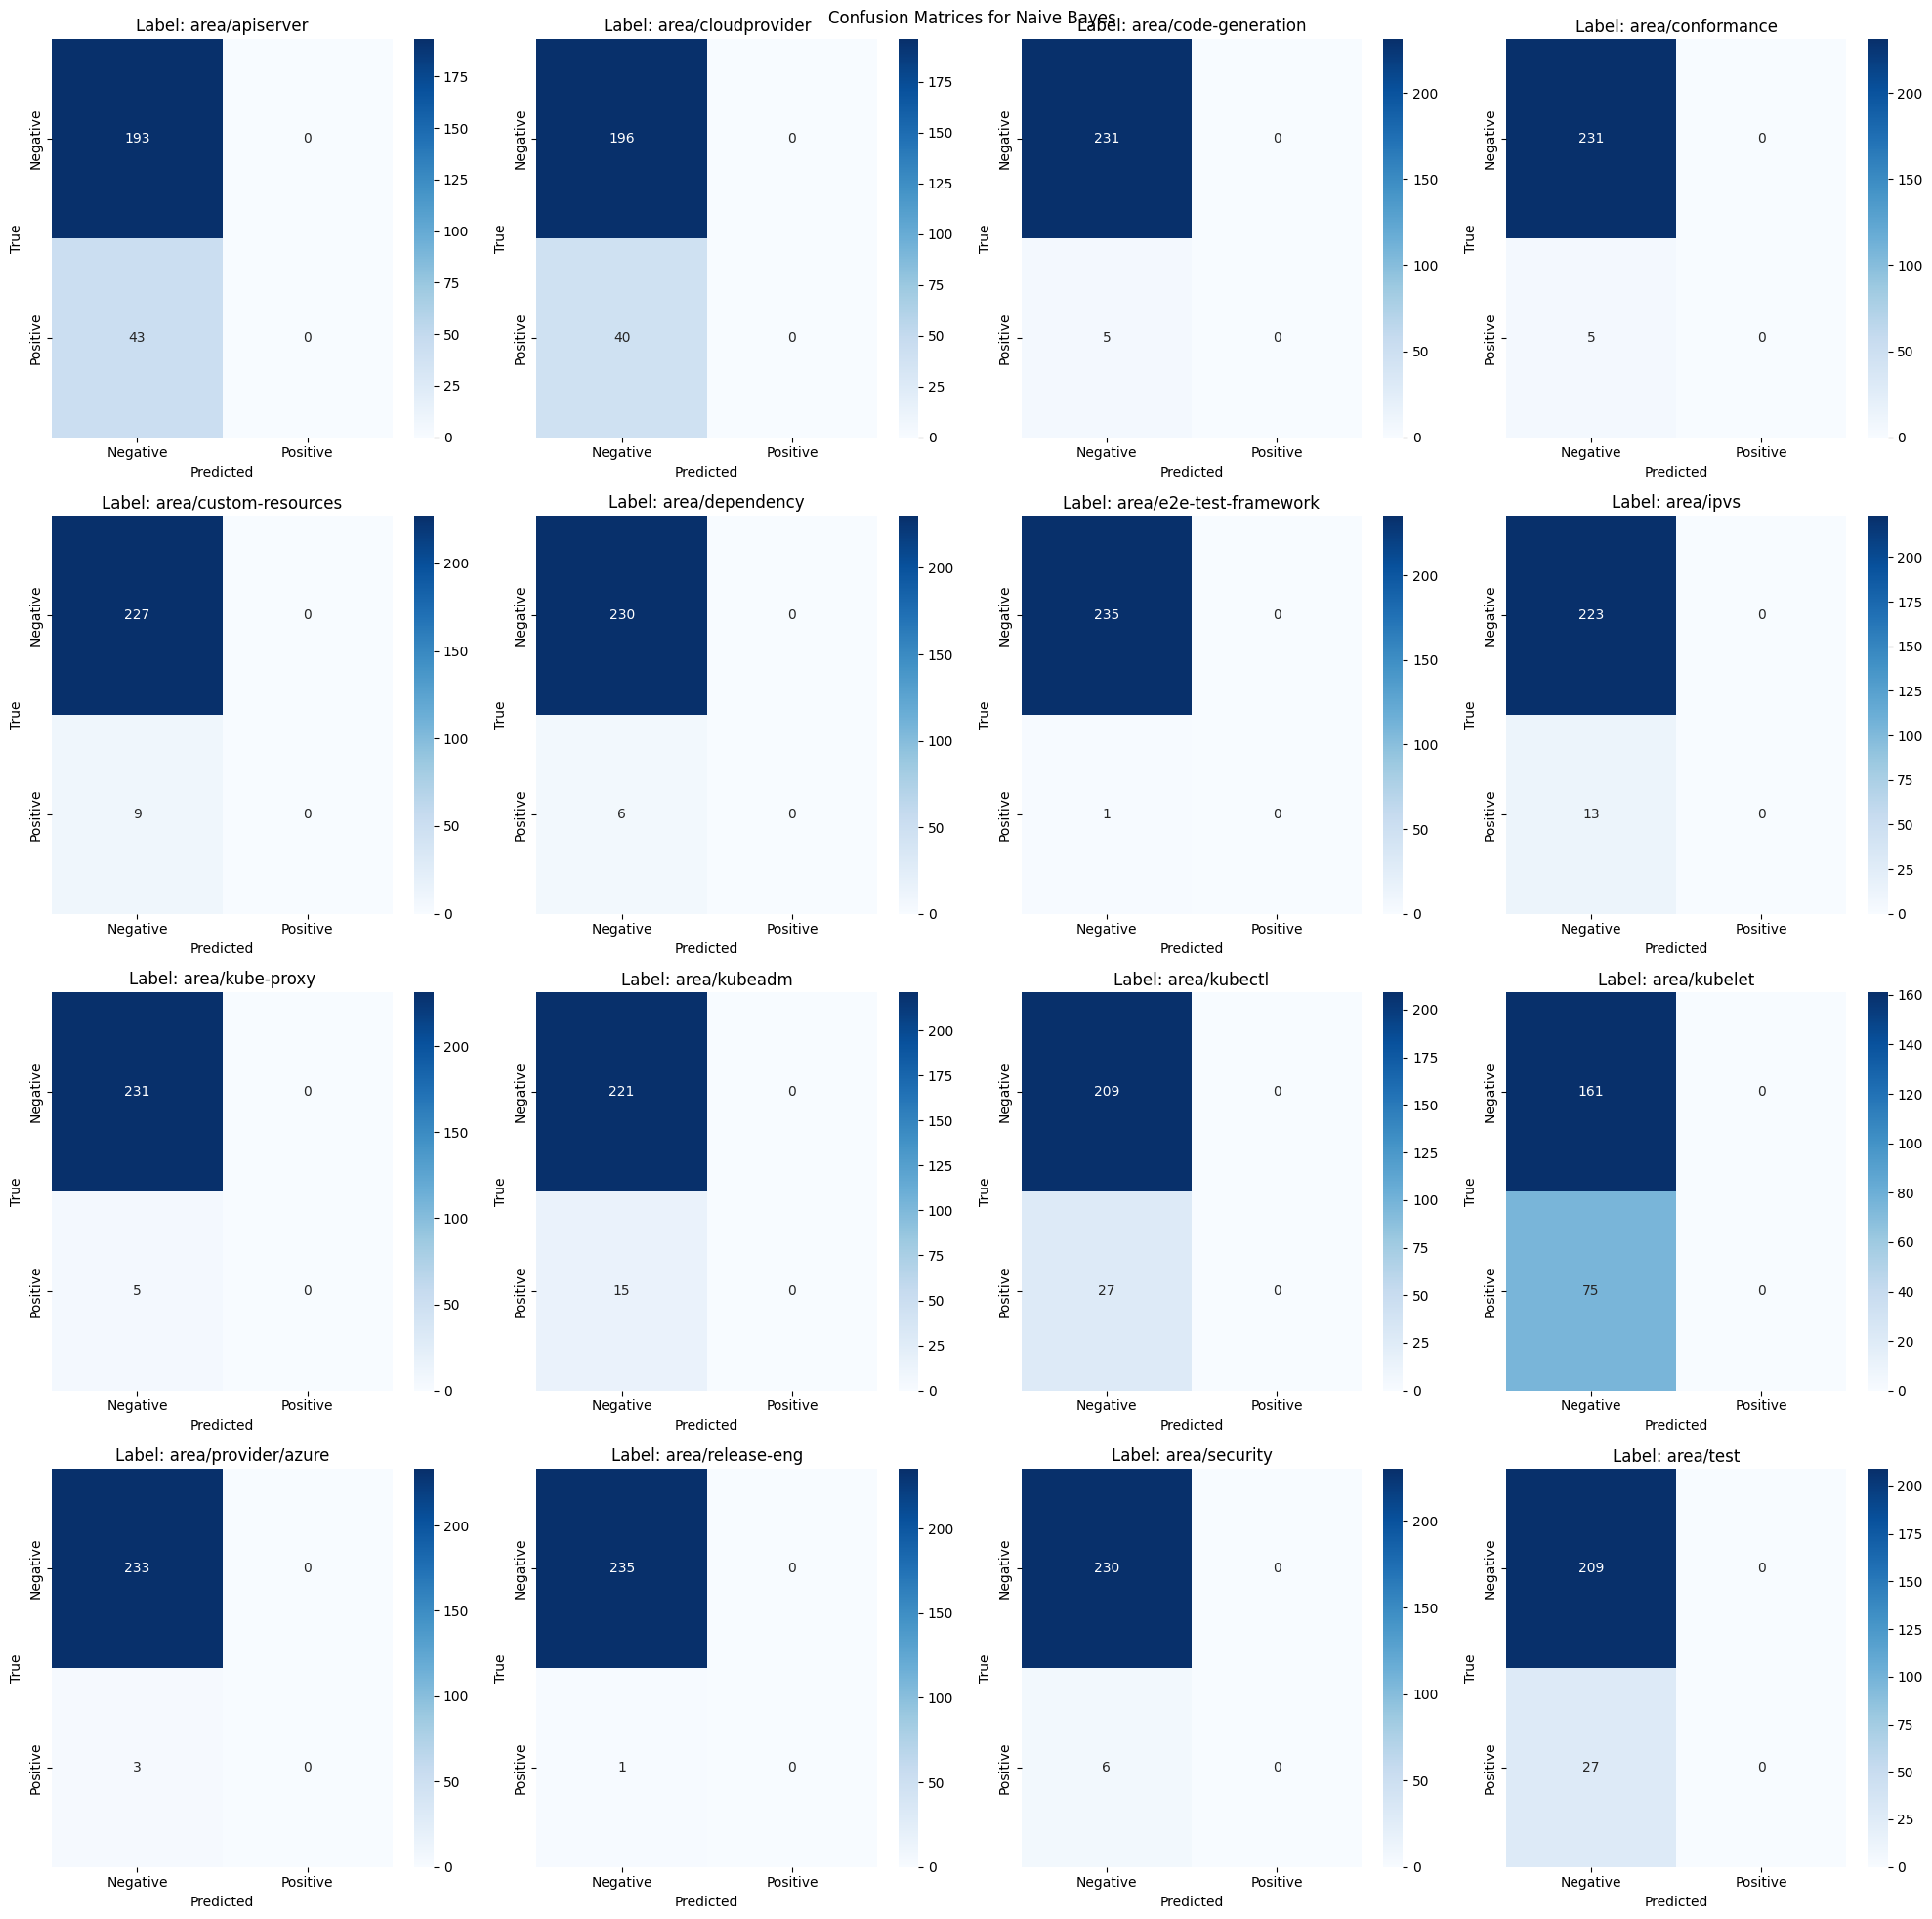

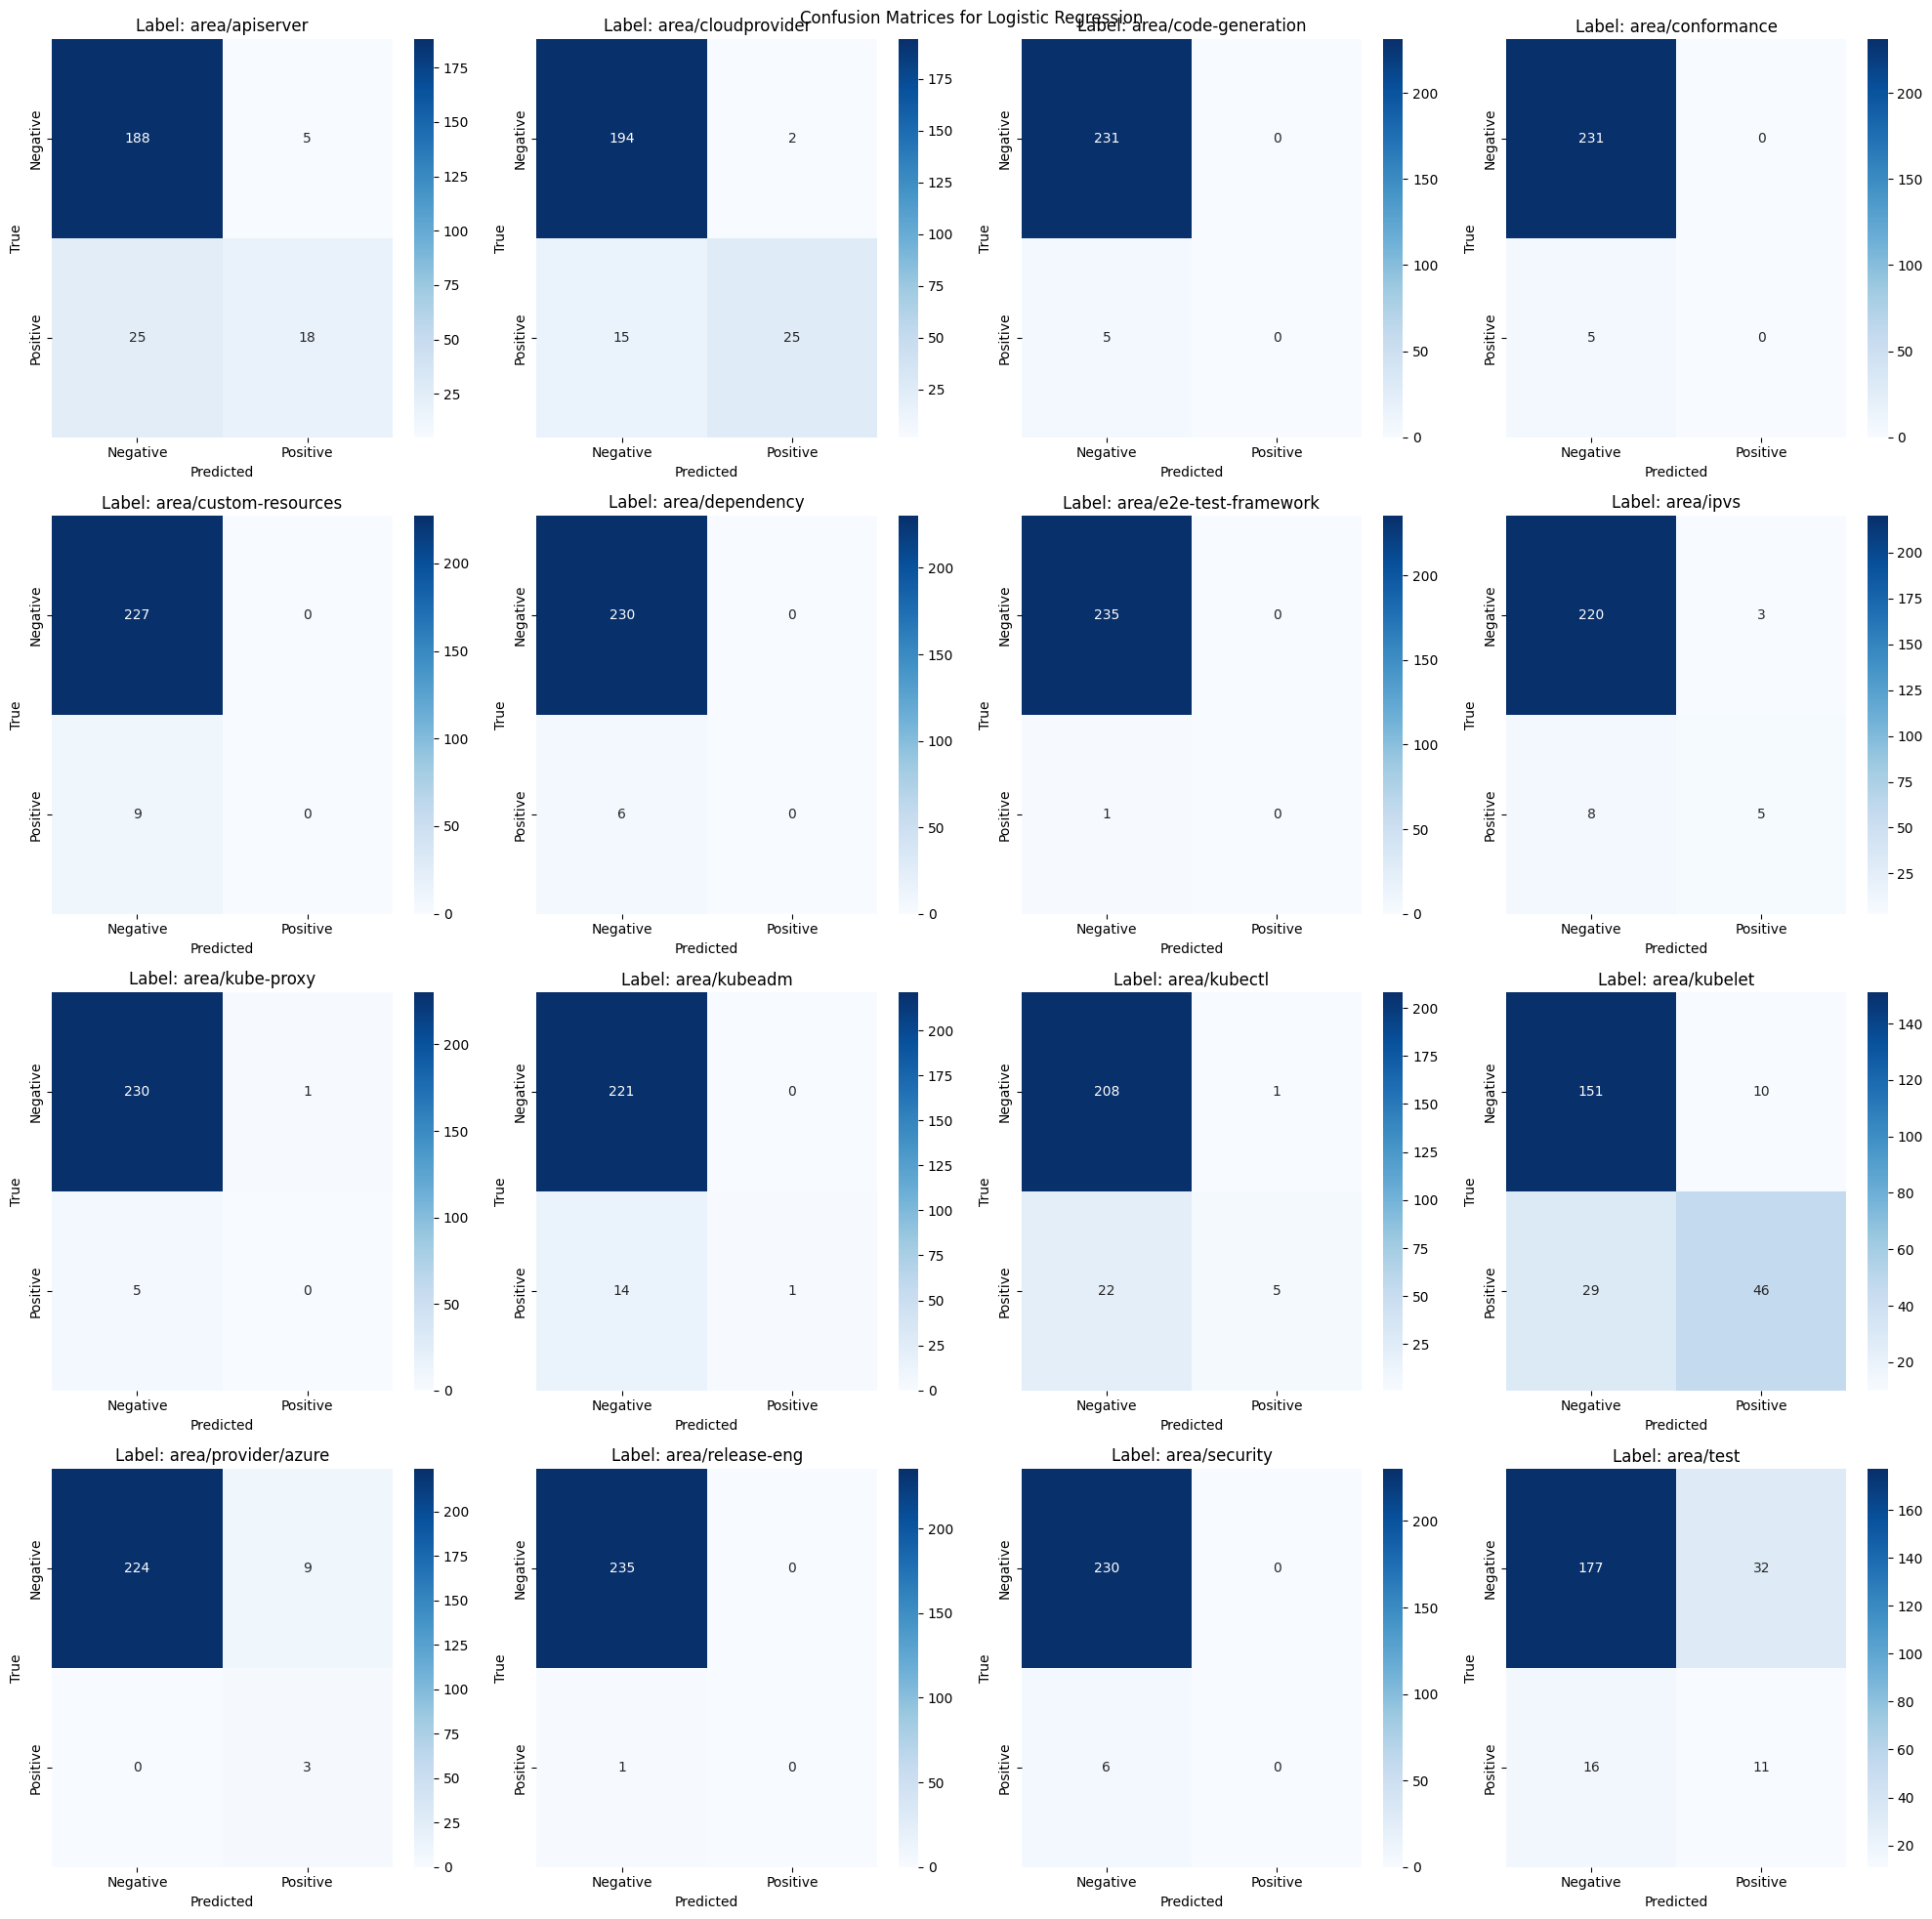

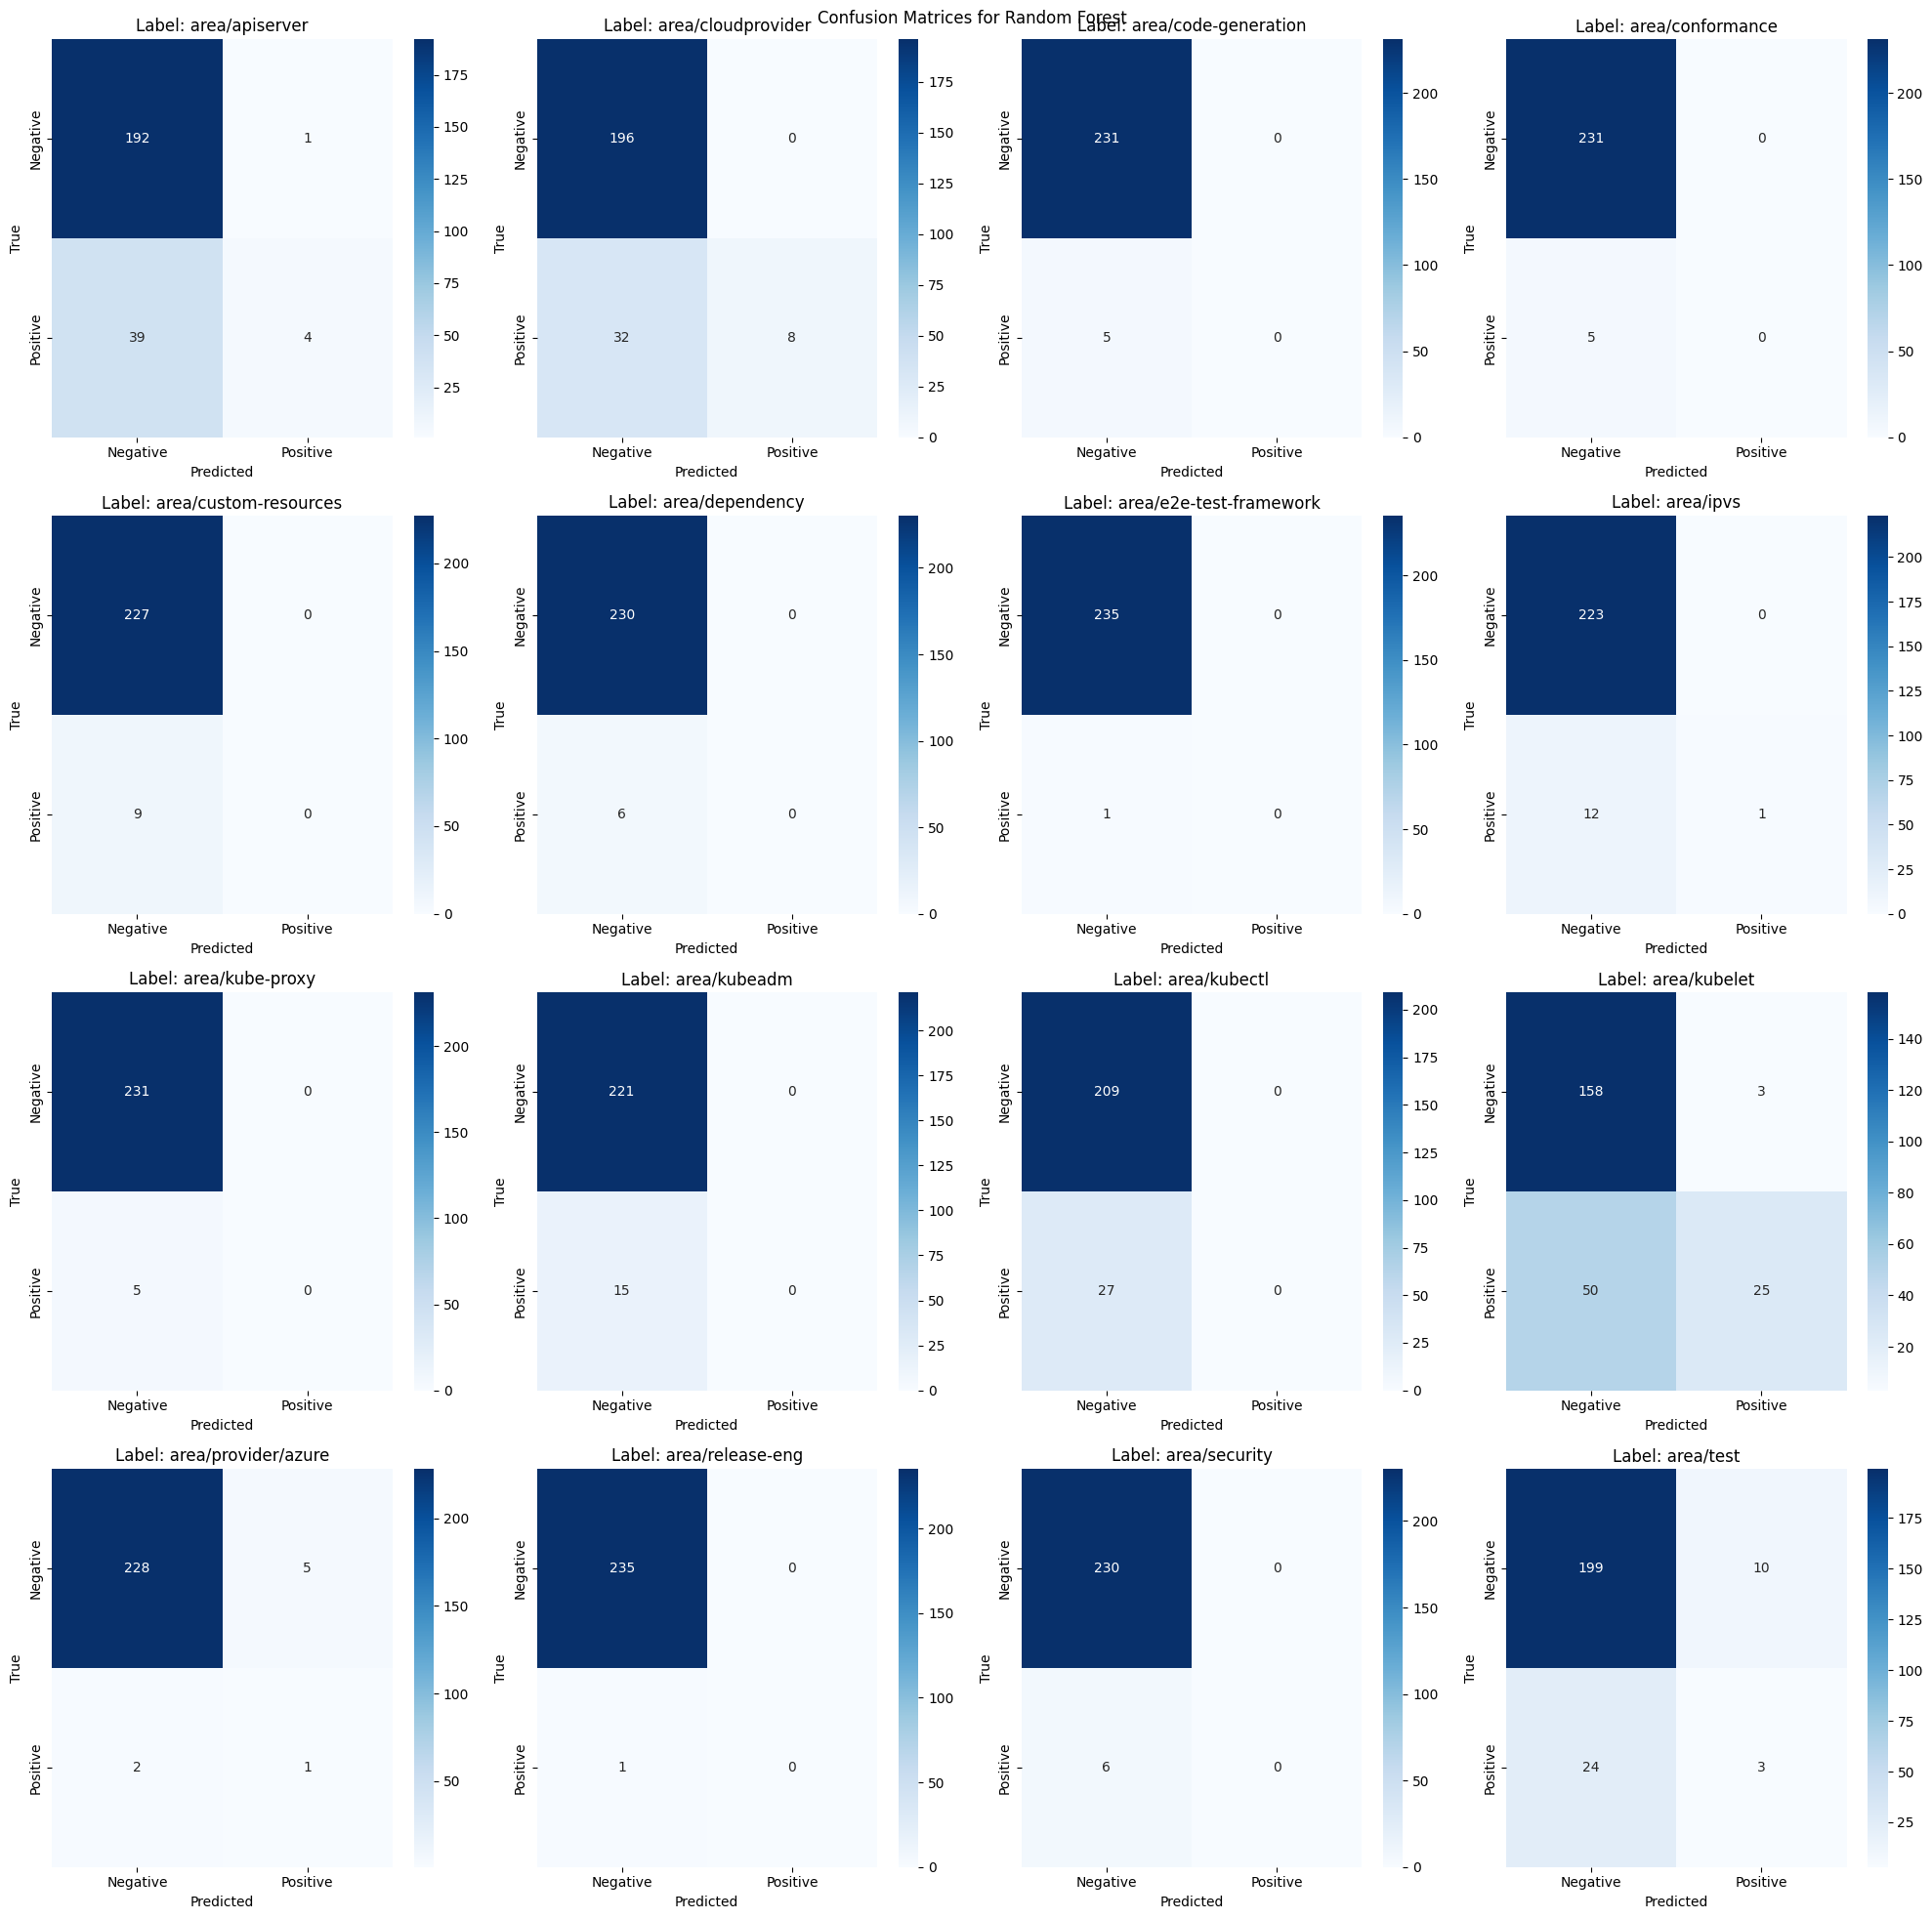

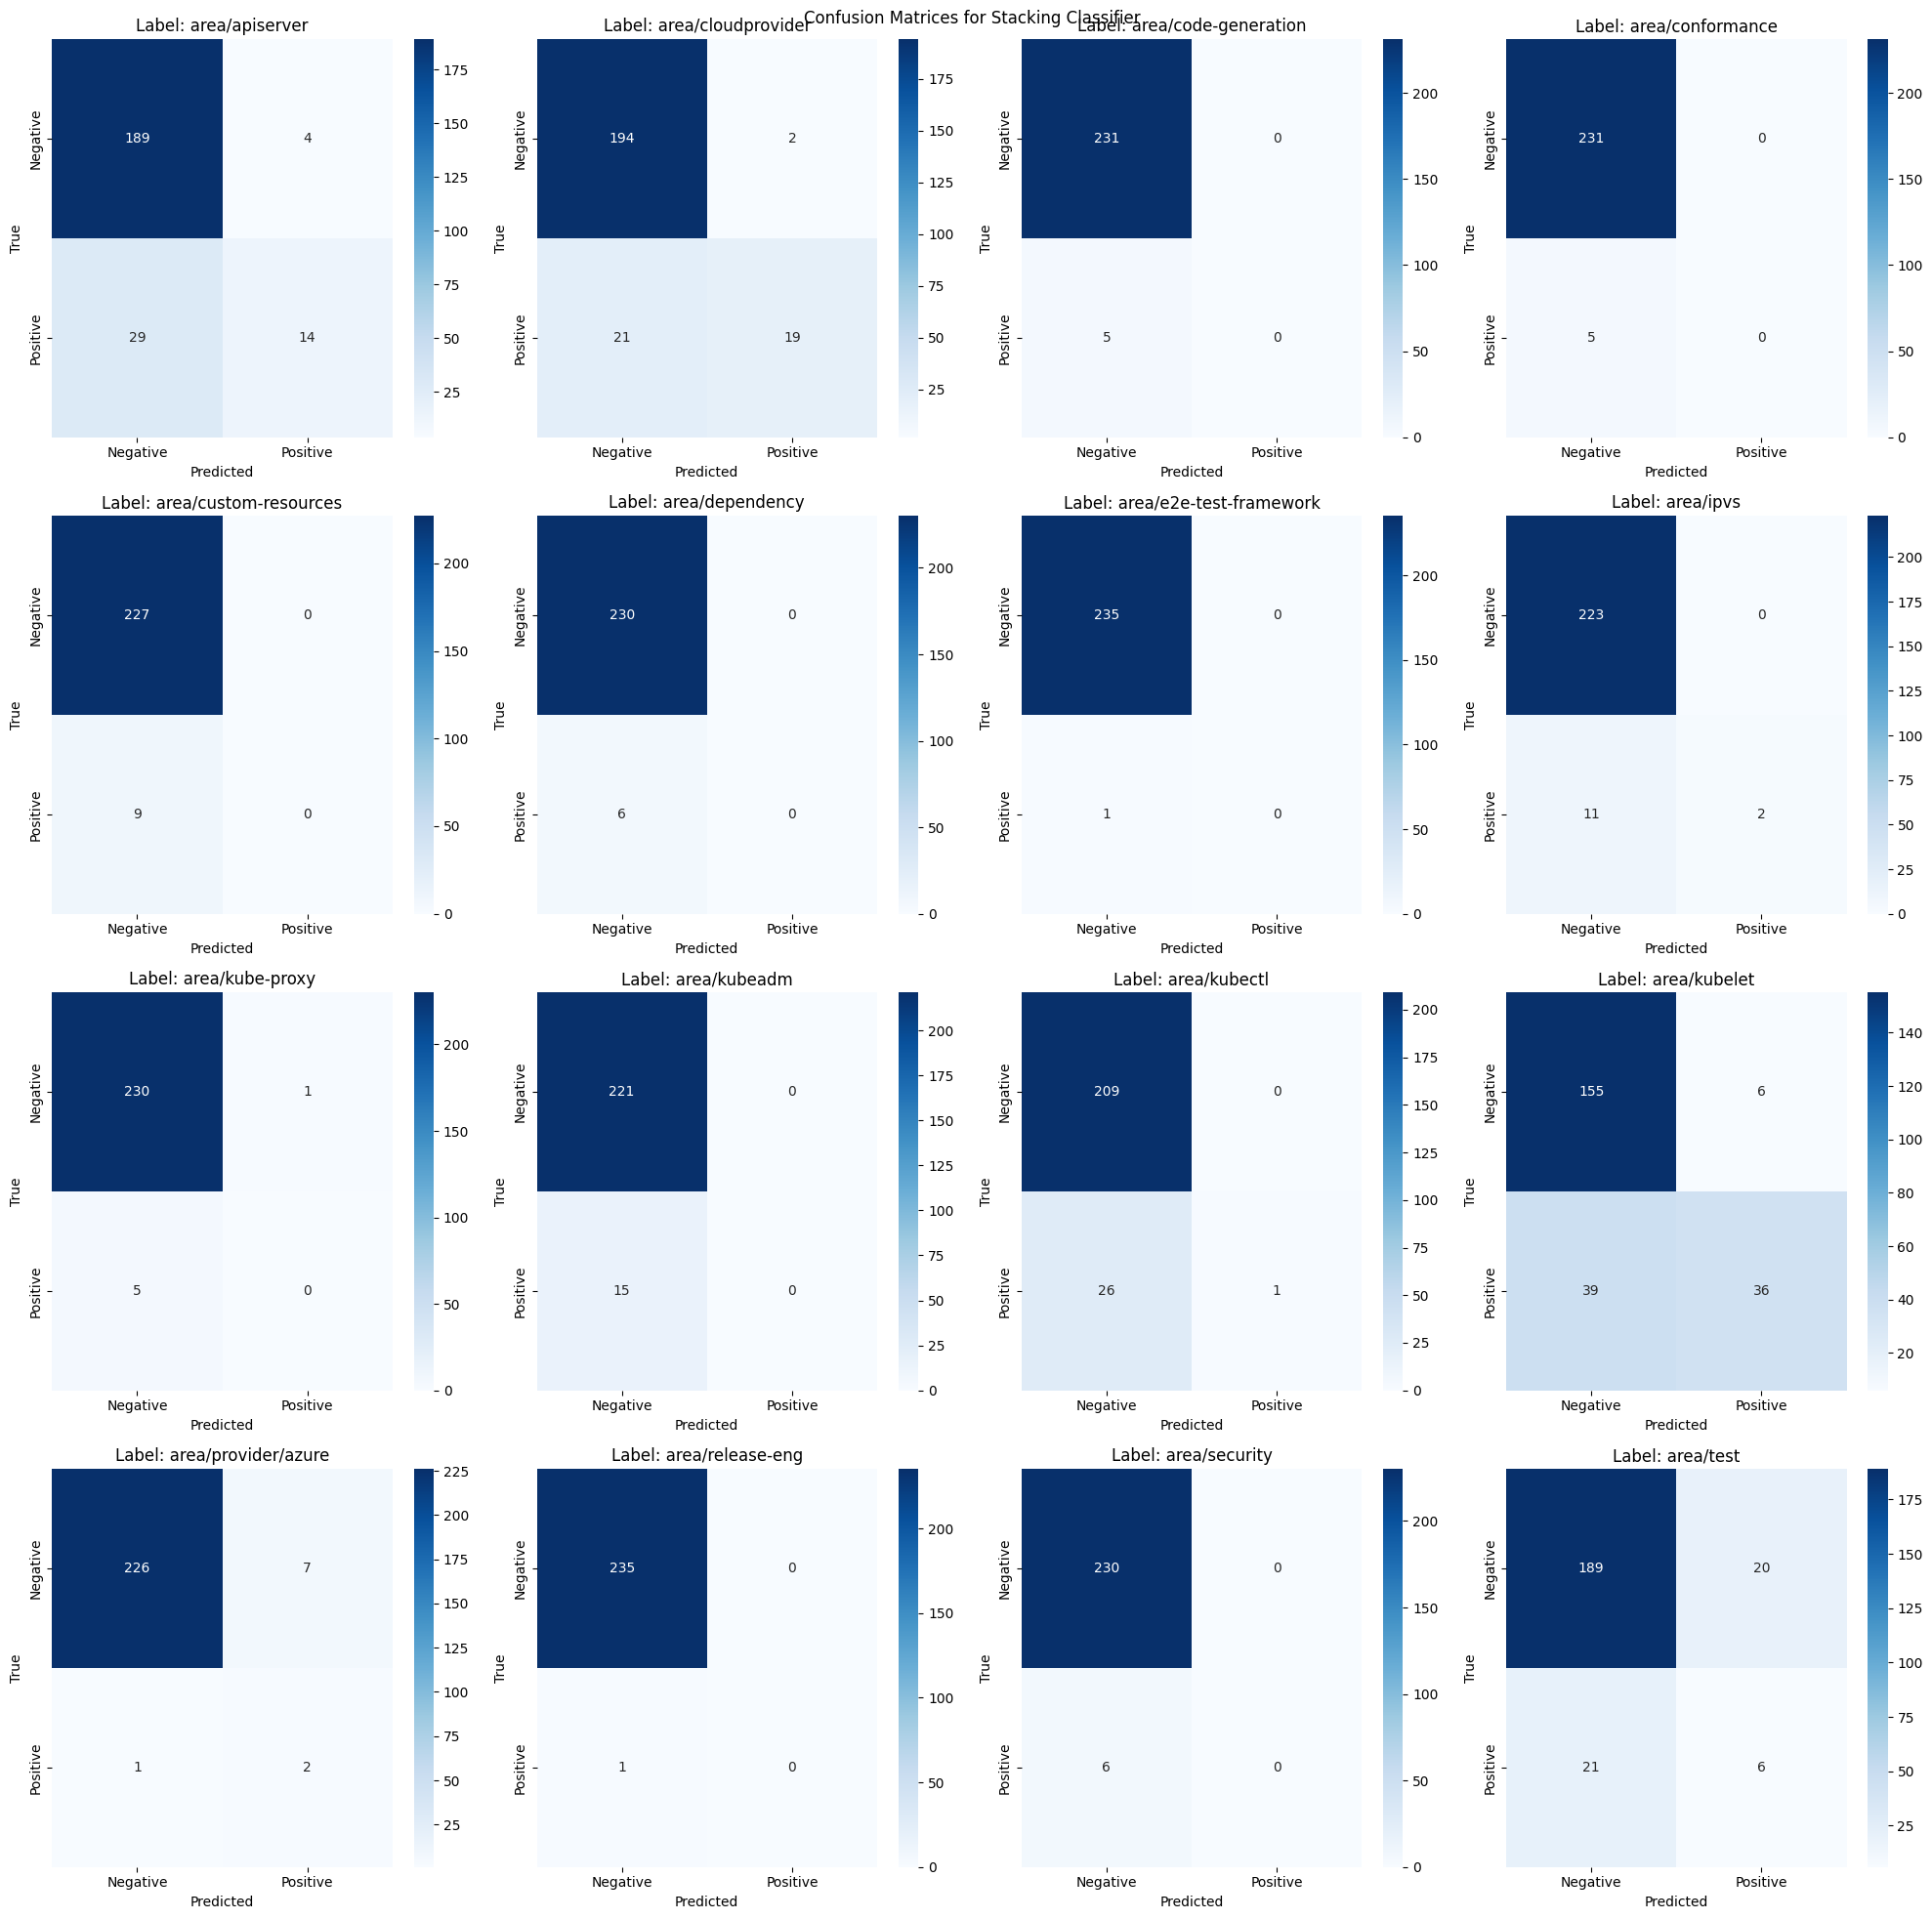

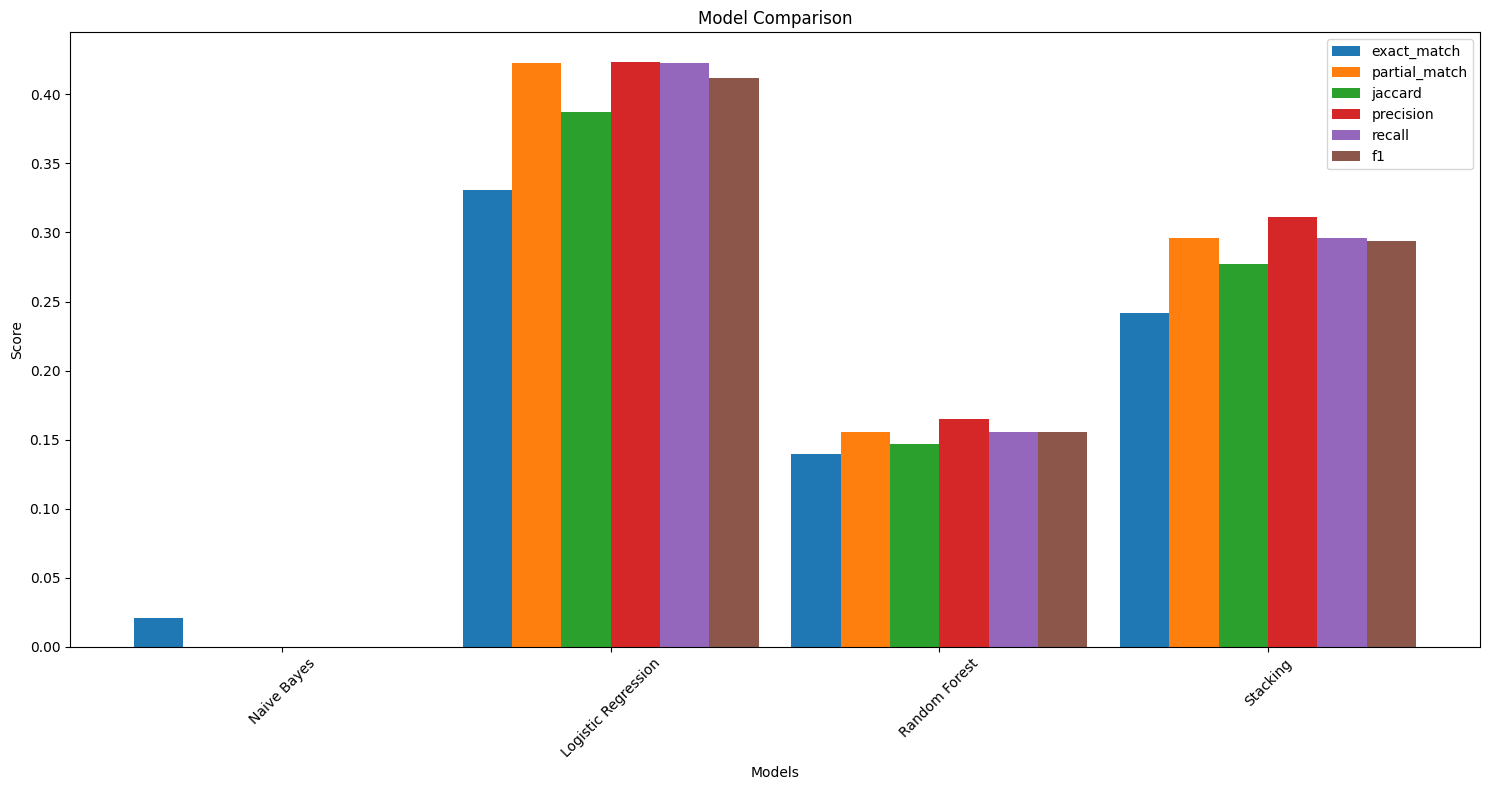

In [123]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Train multiple ML models with SBERT embeddings for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=0, help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--n_estimators', type=int, default=100, help='Number of trees in Random Forest')
    parser.add_argument('--max_depth', type=int, default=None, help='Maximum depth of trees')
    parser.add_argument('--min_samples_split', type=int, default=2, help='Minimum samples required to split')
    parser.add_argument('--min_samples_leaf', type=int, default=1, help='Minimum samples in leaf nodes')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args) 

# Fine Tune SBERT

Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 2 occurrences: 52
Removed 57 infrequent label combinations
Number of samples with frequent label combinations: 1201
Final number of samples after all filtering: 1177

 Label Distribution : 
0. area/kubelet: 358
1. area/test: 303
2. area/apiserver: 209
3. area/cloudprovider: 183
4. area/kubectl: 135
5. area/provider/azure: 66
6. area/dependency: 64
7. area/code-generation: 48
8. area/ipvs: 44
9. area/kubeadm: 39
10. area/kube-proxy: 27
11. area/provider/gcp: 22
12. area/e2e-test-framework: 17
13. area/conformance: 16
14. area/custom-resources: 15
15. area/release-eng: 14
16. area/security: 10
17. area/etcd: 5
18. area/provider/openstack: 5
19. area/provider/vmware: 2

 Label count per row distribution:
L

Validating: 100%|██████████| 59/59 [00:05<00:00, 11.41it/s]


Train Loss: 0.5675
Train Metrics - Exact Match: 0.0244, Precision: 0.0135, Recall: 0.0226, F1: 0.0143
Val Loss: 0.4553
Val Metrics - Exact Match: 0.0212, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch 2/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.37it/s]


Train Loss: 0.3937
Train Metrics - Exact Match: 0.0234, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Val Loss: 0.3192
Val Metrics - Exact Match: 0.0212, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch 3/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.51it/s]


Train Loss: 0.2966
Train Metrics - Exact Match: 0.0234, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Val Loss: 0.2605
Val Metrics - Exact Match: 0.0212, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch 4/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.51it/s]


Train Loss: 0.2592
Train Metrics - Exact Match: 0.0234, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Val Loss: 0.2417
Val Metrics - Exact Match: 0.0212, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch 5/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.51it/s]


Train Loss: 0.2477
Train Metrics - Exact Match: 0.0234, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Val Loss: 0.2350
Val Metrics - Exact Match: 0.0212, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch 6/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.54it/s]


Train Loss: 0.2359
Train Metrics - Exact Match: 0.0234, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Val Loss: 0.2280
Val Metrics - Exact Match: 0.0212, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

Epoch 7/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.51it/s]


Train Loss: 0.2221
Train Metrics - Exact Match: 0.0234, Precision: 0.0021, Recall: 0.0007, F1: 0.0010
Val Loss: 0.2184
Val Metrics - Exact Match: 0.0212, Precision: 0.0127, Recall: 0.0049, F1: 0.0071
Saved new best model

Epoch 8/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.37it/s]


Train Loss: 0.2077
Train Metrics - Exact Match: 0.0691, Precision: 0.0755, Recall: 0.0568, F1: 0.0614
Val Loss: 0.2062
Val Metrics - Exact Match: 0.0975, Precision: 0.0975, Recall: 0.0847, F1: 0.0883
Saved new best model

Epoch 9/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.63it/s]


Train Loss: 0.1918
Train Metrics - Exact Match: 0.2040, Precision: 0.2519, Recall: 0.2118, F1: 0.2233
Val Loss: 0.1950
Val Metrics - Exact Match: 0.2881, Precision: 0.3220, Recall: 0.2924, F1: 0.3014
Saved new best model

Epoch 10/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.57it/s]


Train Loss: 0.1780
Train Metrics - Exact Match: 0.2848, Precision: 0.3943, Recall: 0.3240, F1: 0.3457
Val Loss: 0.1851
Val Metrics - Exact Match: 0.3305, Precision: 0.3898, Recall: 0.3477, F1: 0.3609
Saved new best model

Epoch 11/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.51it/s]


Train Loss: 0.1647
Train Metrics - Exact Match: 0.3634, Precision: 0.5170, Recall: 0.4244, F1: 0.4528
Val Loss: 0.1760
Val Metrics - Exact Match: 0.3305, Precision: 0.3962, Recall: 0.3548, F1: 0.3680
Saved new best model

Epoch 12/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.46it/s]


Train Loss: 0.1505
Train Metrics - Exact Match: 0.4357, Precision: 0.6180, Recall: 0.5145, F1: 0.5475
Val Loss: 0.1684
Val Metrics - Exact Match: 0.4322, Precision: 0.5381, Recall: 0.4812, F1: 0.4993
Saved new best model

Epoch 13/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.52it/s]


Train Loss: 0.1393
Train Metrics - Exact Match: 0.4920, Precision: 0.6840, Recall: 0.5770, F1: 0.6118
Val Loss: 0.1659
Val Metrics - Exact Match: 0.3771, Precision: 0.4936, Recall: 0.4480, F1: 0.4589

Epoch 14/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.52it/s]


Train Loss: 0.1291
Train Metrics - Exact Match: 0.5356, Precision: 0.6963, Recall: 0.6118, F1: 0.6374
Val Loss: 0.1578
Val Metrics - Exact Match: 0.4237, Precision: 0.5445, Recall: 0.4904, F1: 0.5048
Saved new best model

Epoch 15/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.44it/s]


Train Loss: 0.1201
Train Metrics - Exact Match: 0.5685, Precision: 0.7155, Recall: 0.6407, F1: 0.6633
Val Loss: 0.1523
Val Metrics - Exact Match: 0.4110, Precision: 0.5403, Recall: 0.5204, F1: 0.5167
Saved new best model

Epoch 16/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.46it/s]


Train Loss: 0.1113
Train Metrics - Exact Match: 0.6079, Precision: 0.7396, Recall: 0.6712, F1: 0.6929
Val Loss: 0.1494
Val Metrics - Exact Match: 0.4280, Precision: 0.5699, Recall: 0.5628, F1: 0.5519
Saved new best model

Epoch 17/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.49it/s]


Train Loss: 0.1035
Train Metrics - Exact Match: 0.6387, Precision: 0.7665, Recall: 0.7049, F1: 0.7235
Val Loss: 0.1438
Val Metrics - Exact Match: 0.4407, Precision: 0.5911, Recall: 0.5790, F1: 0.5684
Saved new best model

Epoch 18/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.41it/s]


Train Loss: 0.0972
Train Metrics - Exact Match: 0.6748, Precision: 0.7909, Recall: 0.7341, F1: 0.7514
Val Loss: 0.1424
Val Metrics - Exact Match: 0.4492, Precision: 0.5890, Recall: 0.5883, F1: 0.5747
Saved new best model

Epoch 19/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.48it/s]


Train Loss: 0.0916
Train Metrics - Exact Match: 0.6982, Precision: 0.8035, Recall: 0.7556, F1: 0.7690
Val Loss: 0.1367
Val Metrics - Exact Match: 0.4915, Precision: 0.6367, Recall: 0.6406, F1: 0.6235
Saved new best model

Epoch 20/20


Validating: 100%|██████████| 59/59 [00:05<00:00, 11.49it/s]


Train Loss: 0.0852
Train Metrics - Exact Match: 0.7258, Precision: 0.8237, Recall: 0.7795, F1: 0.7914
Val Loss: 0.1352
Val Metrics - Exact Match: 0.4831, Precision: 0.6350, Recall: 0.6477, F1: 0.6245
Saved new best model


<ipython-input-122-2e980a684951>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(run_dir, 'best_sbert_model.pt')))



Generating embeddings with model...


Generating embeddings: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Training Naive Bayes...


Making predictions with Naive Bayes...

Naive Bayes Validation Metrics:
exact_match: 0.0212
partial_match: 0.0000
jaccard: 0.0000
precision: 0.0000
recall: 0.0000
f1: 0.0000

Training Logistic Regression...
Making predictions with Logistic Regression...

Logistic Regression Validation Metrics:
exact_match: 0.5805
partial_match: 0.7575
jaccard: 0.6914
precision: 0.7319
recall: 0.7575
f1: 0.7279

Training Random Forest...
Making predictions with Random Forest...

Random Forest Validation Metrics:
exact_match: 0.5678
partial_match: 0.7465
jaccard: 0.6792
precision: 0.7218
recall: 0.7465
f1: 0.7169

Training Stacking Classifier...

Training Stacking Classifier...
Making predictions with Stacking Classifier...

Stacking Classifier Validation Metrics:
exact_match: 0.5508
partial_match: 0.7254
jaccard: 0.6616
precision: 0.7070
recall: 0.7254
f1: 0.6985

Training completed! Results saved to ./results/run_20250317_060250_all_text_0.5


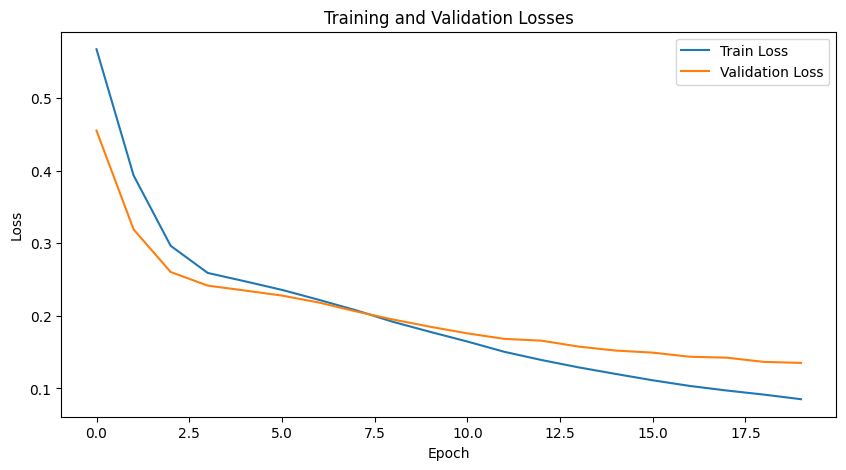

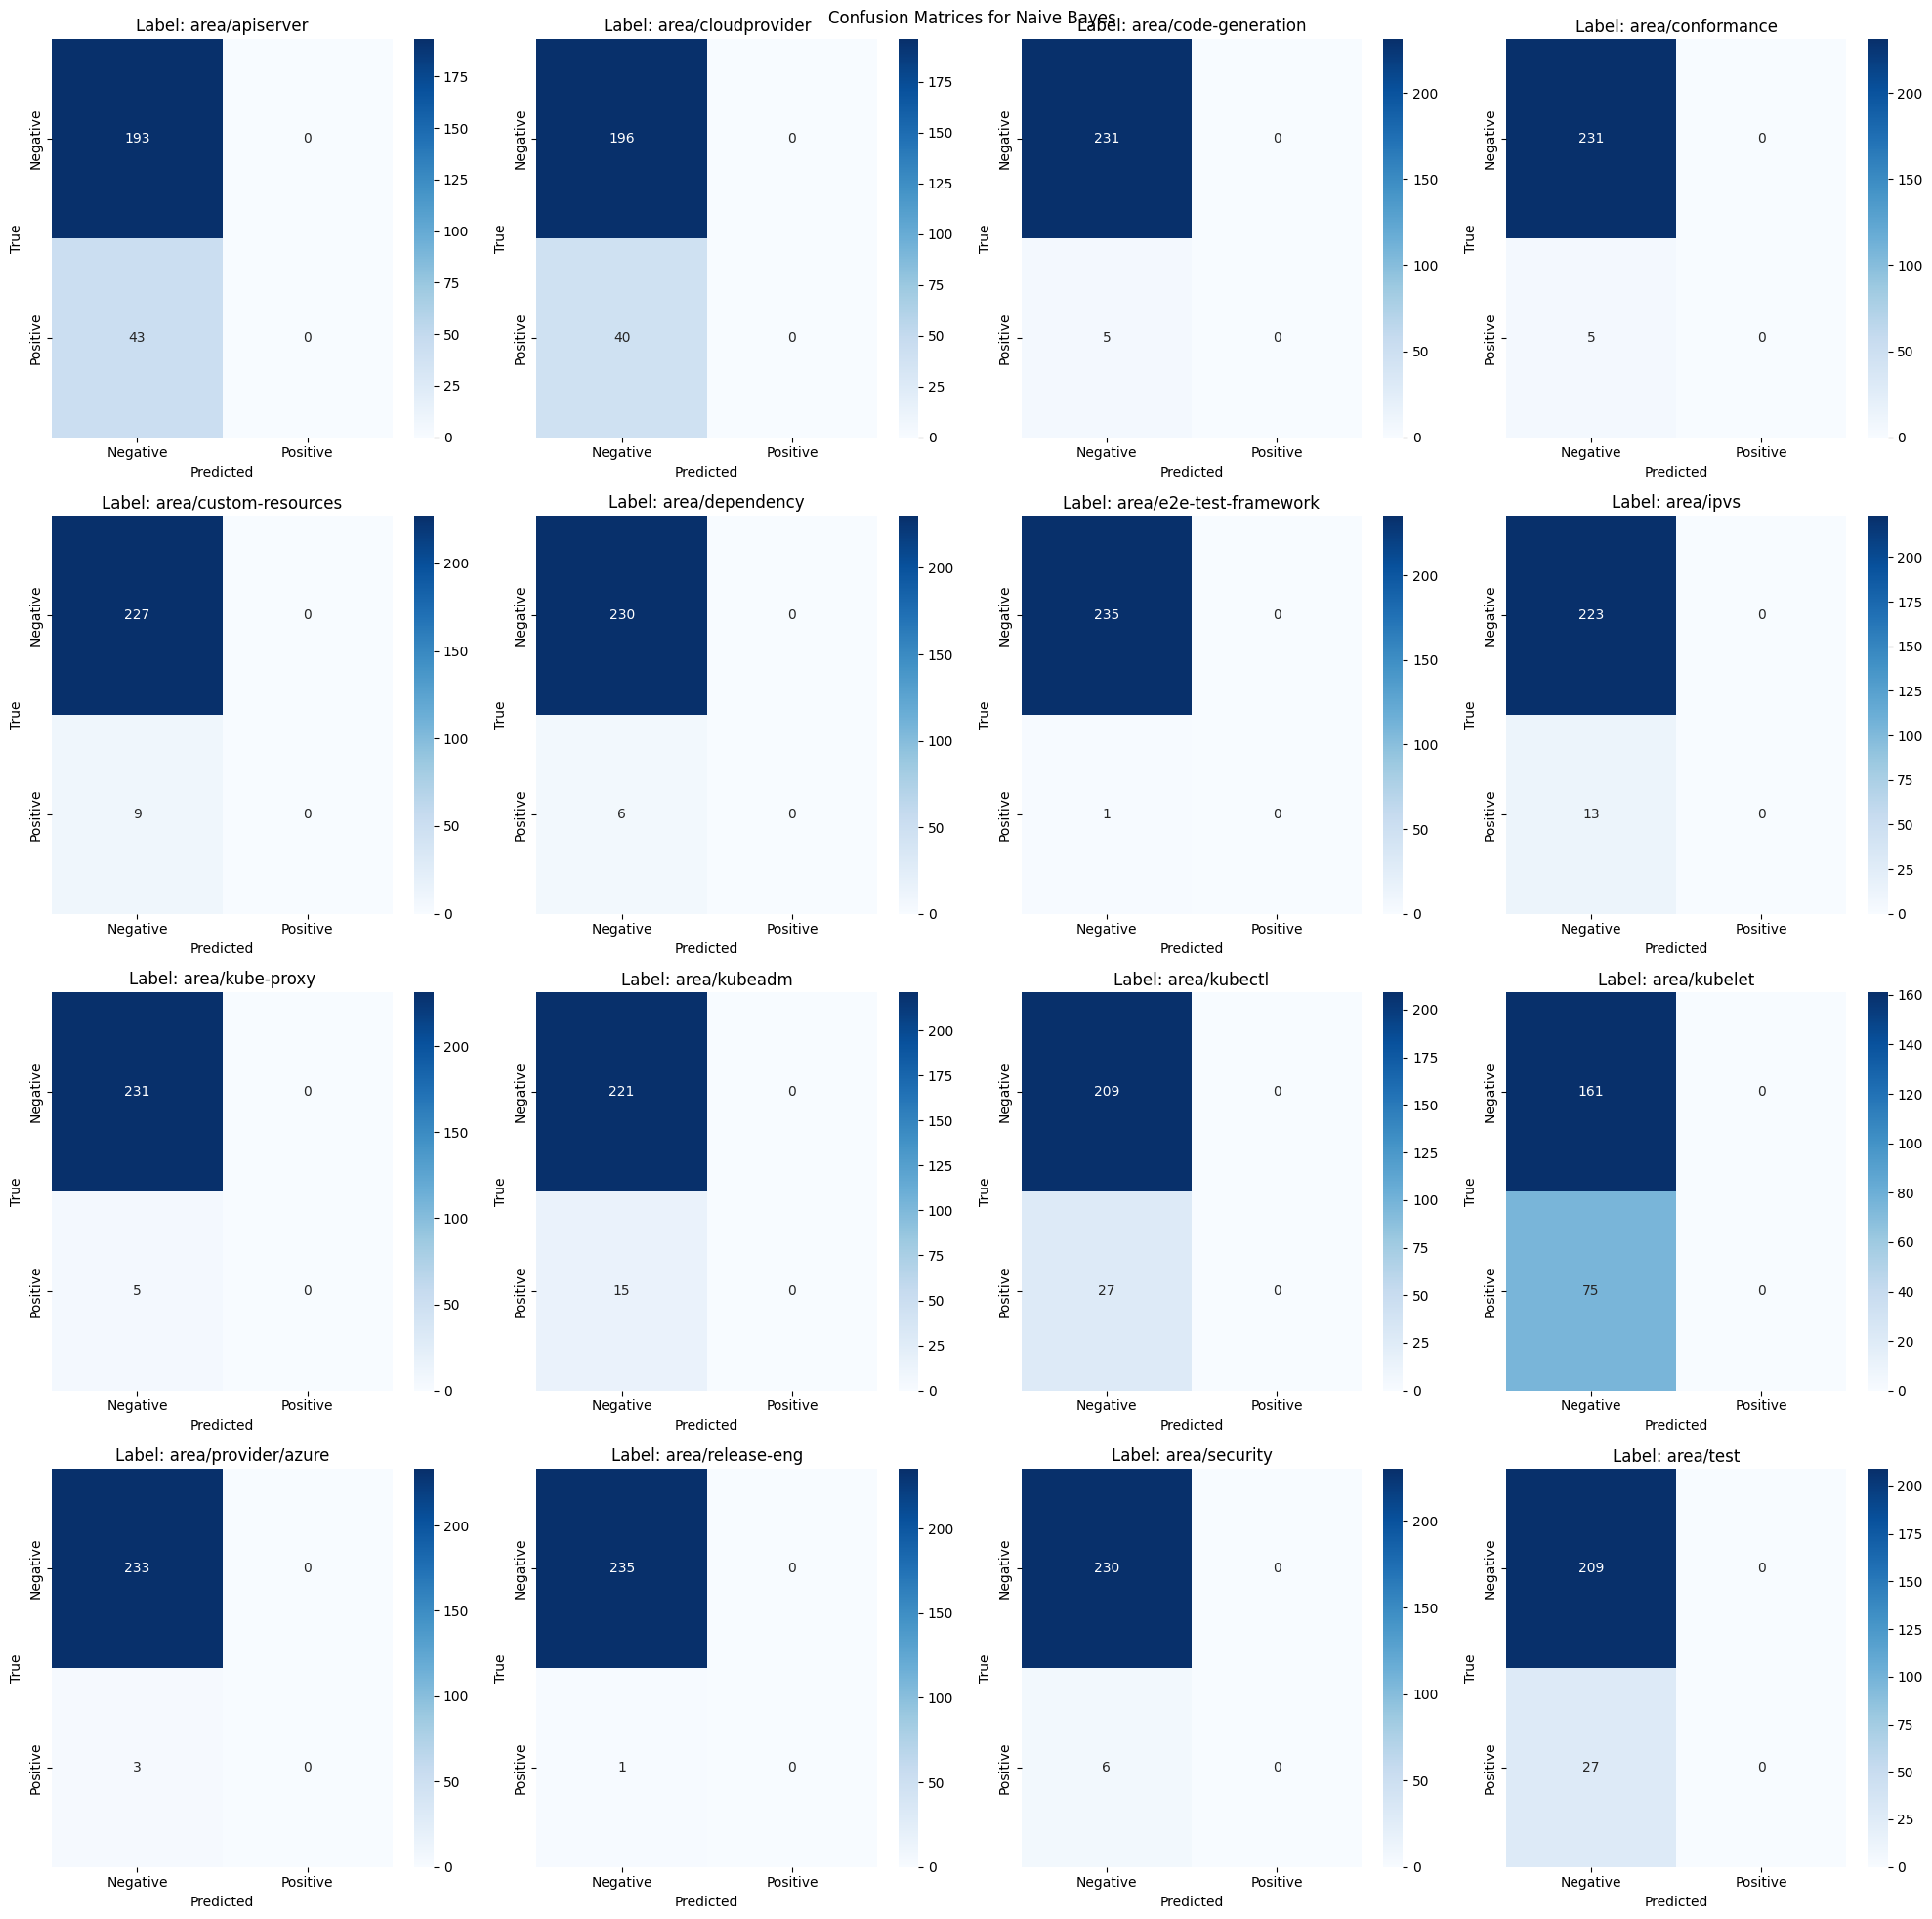

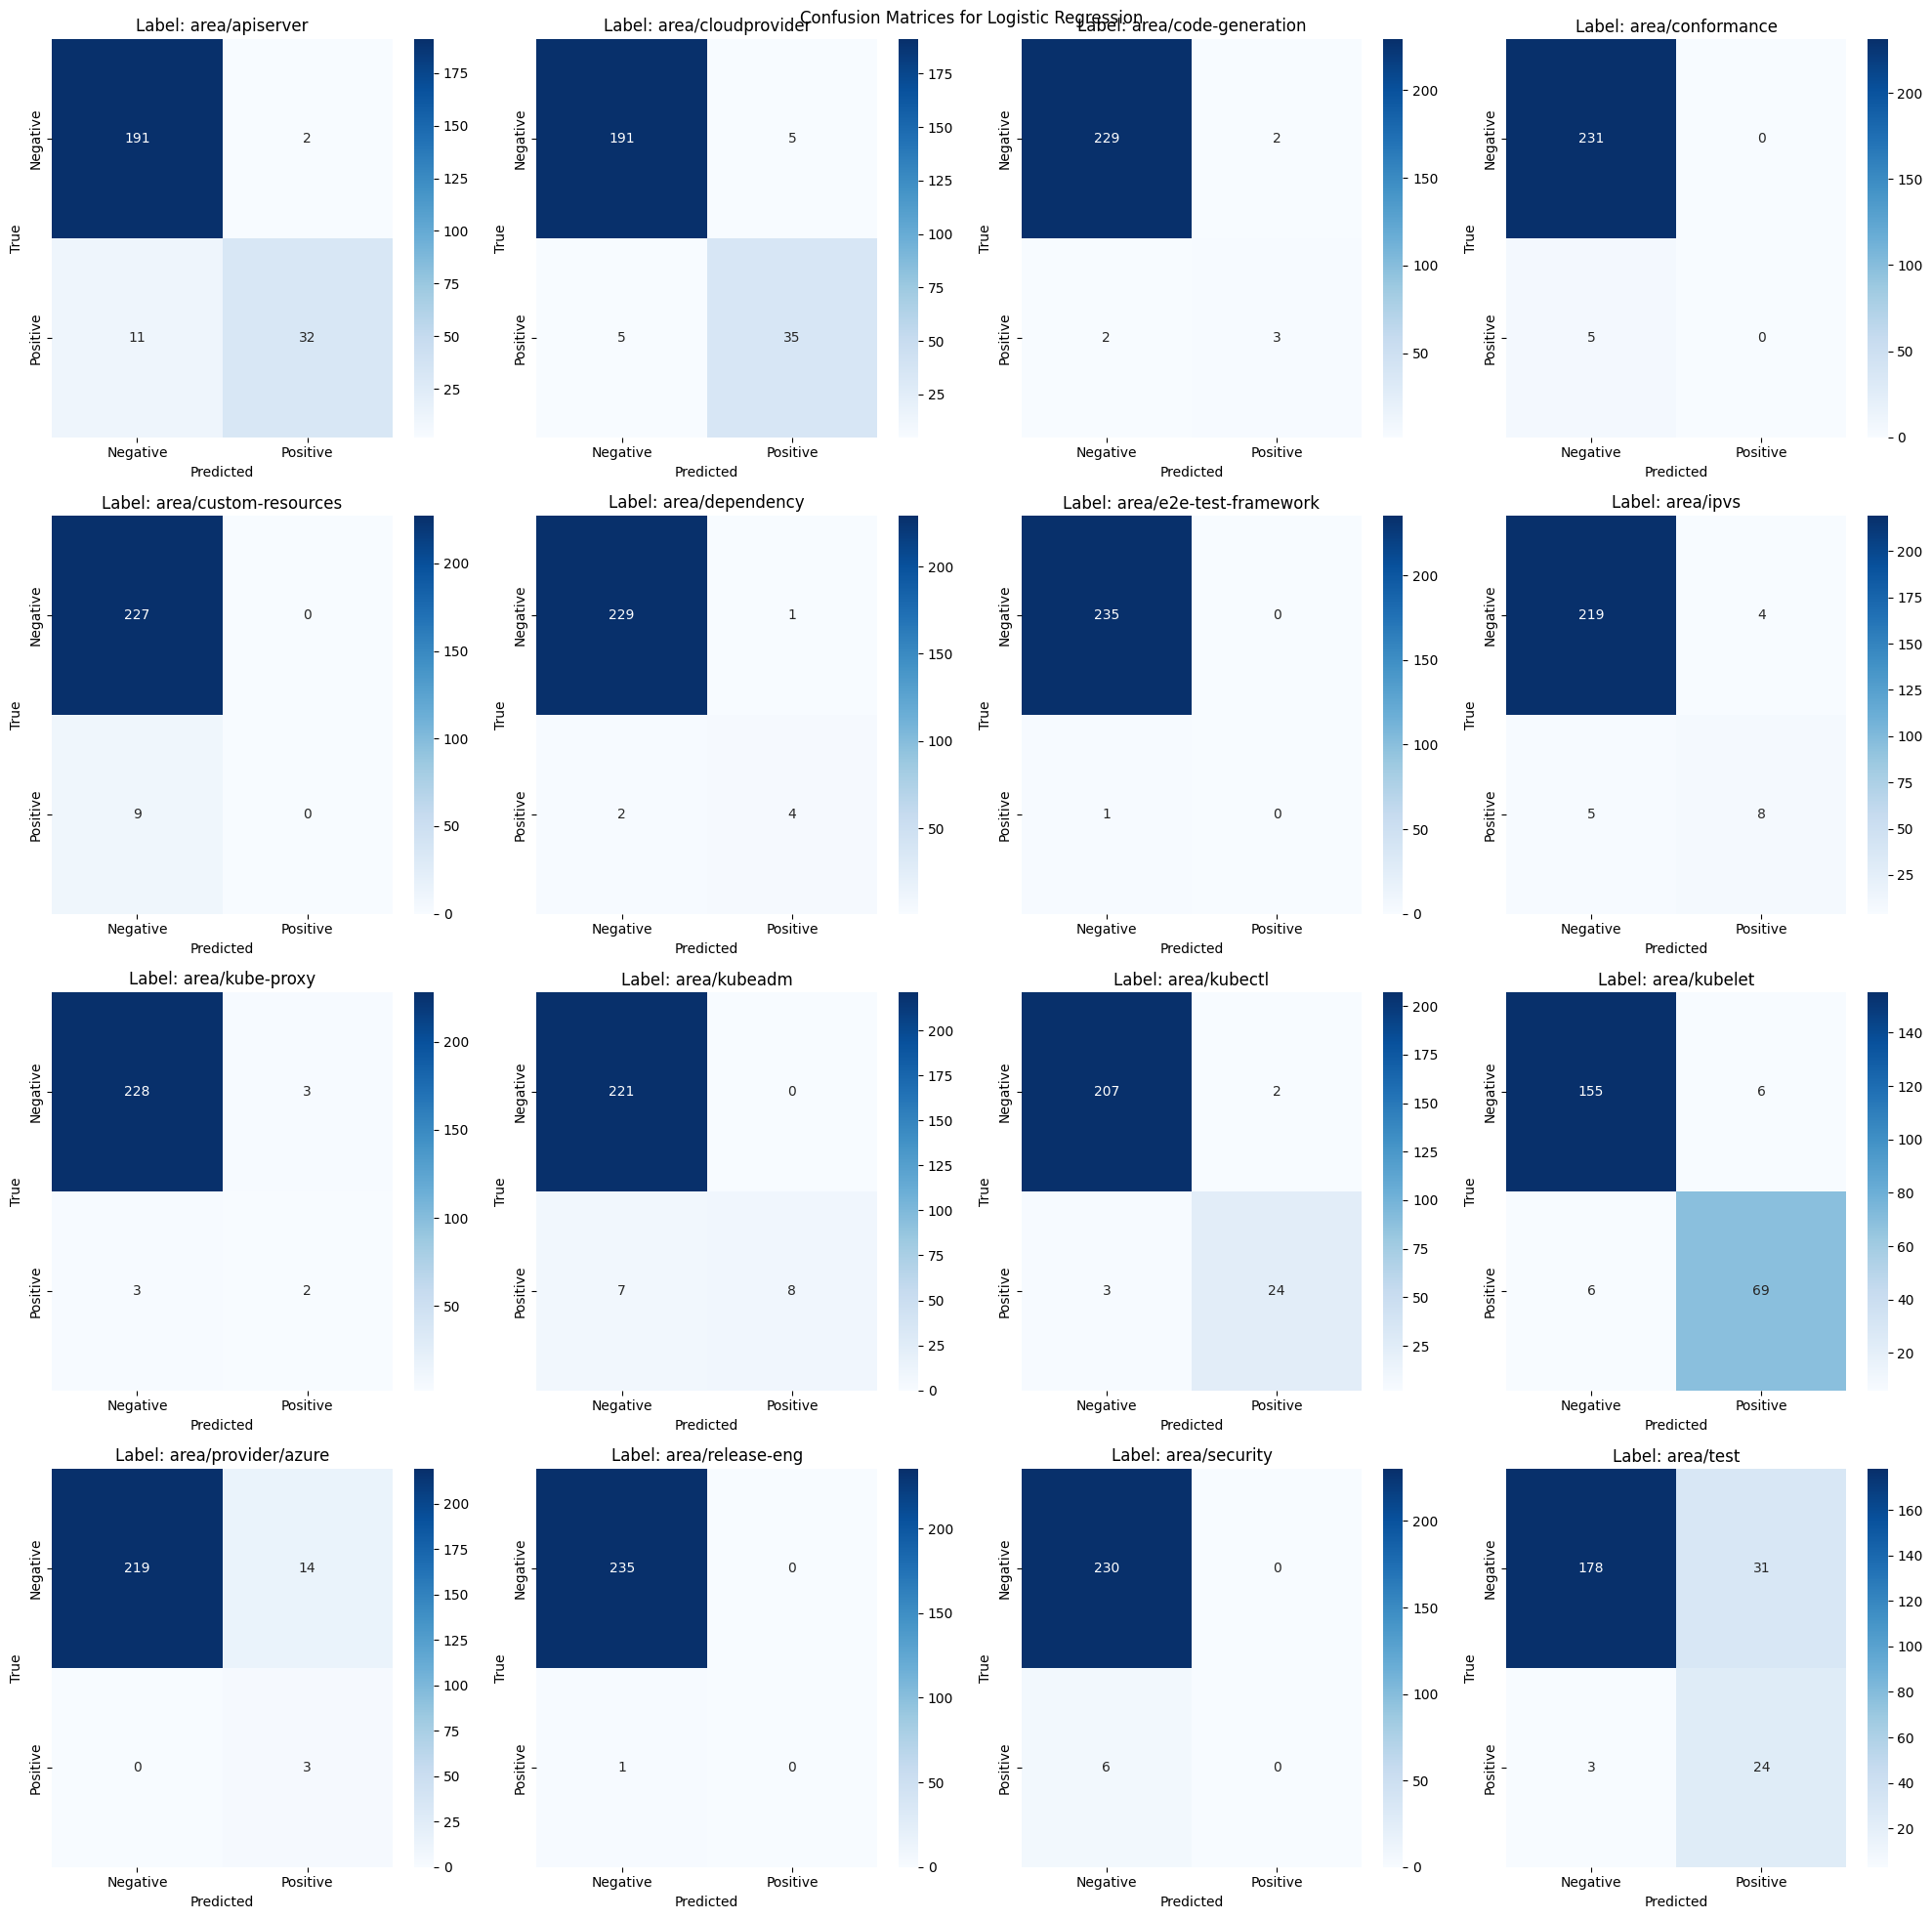

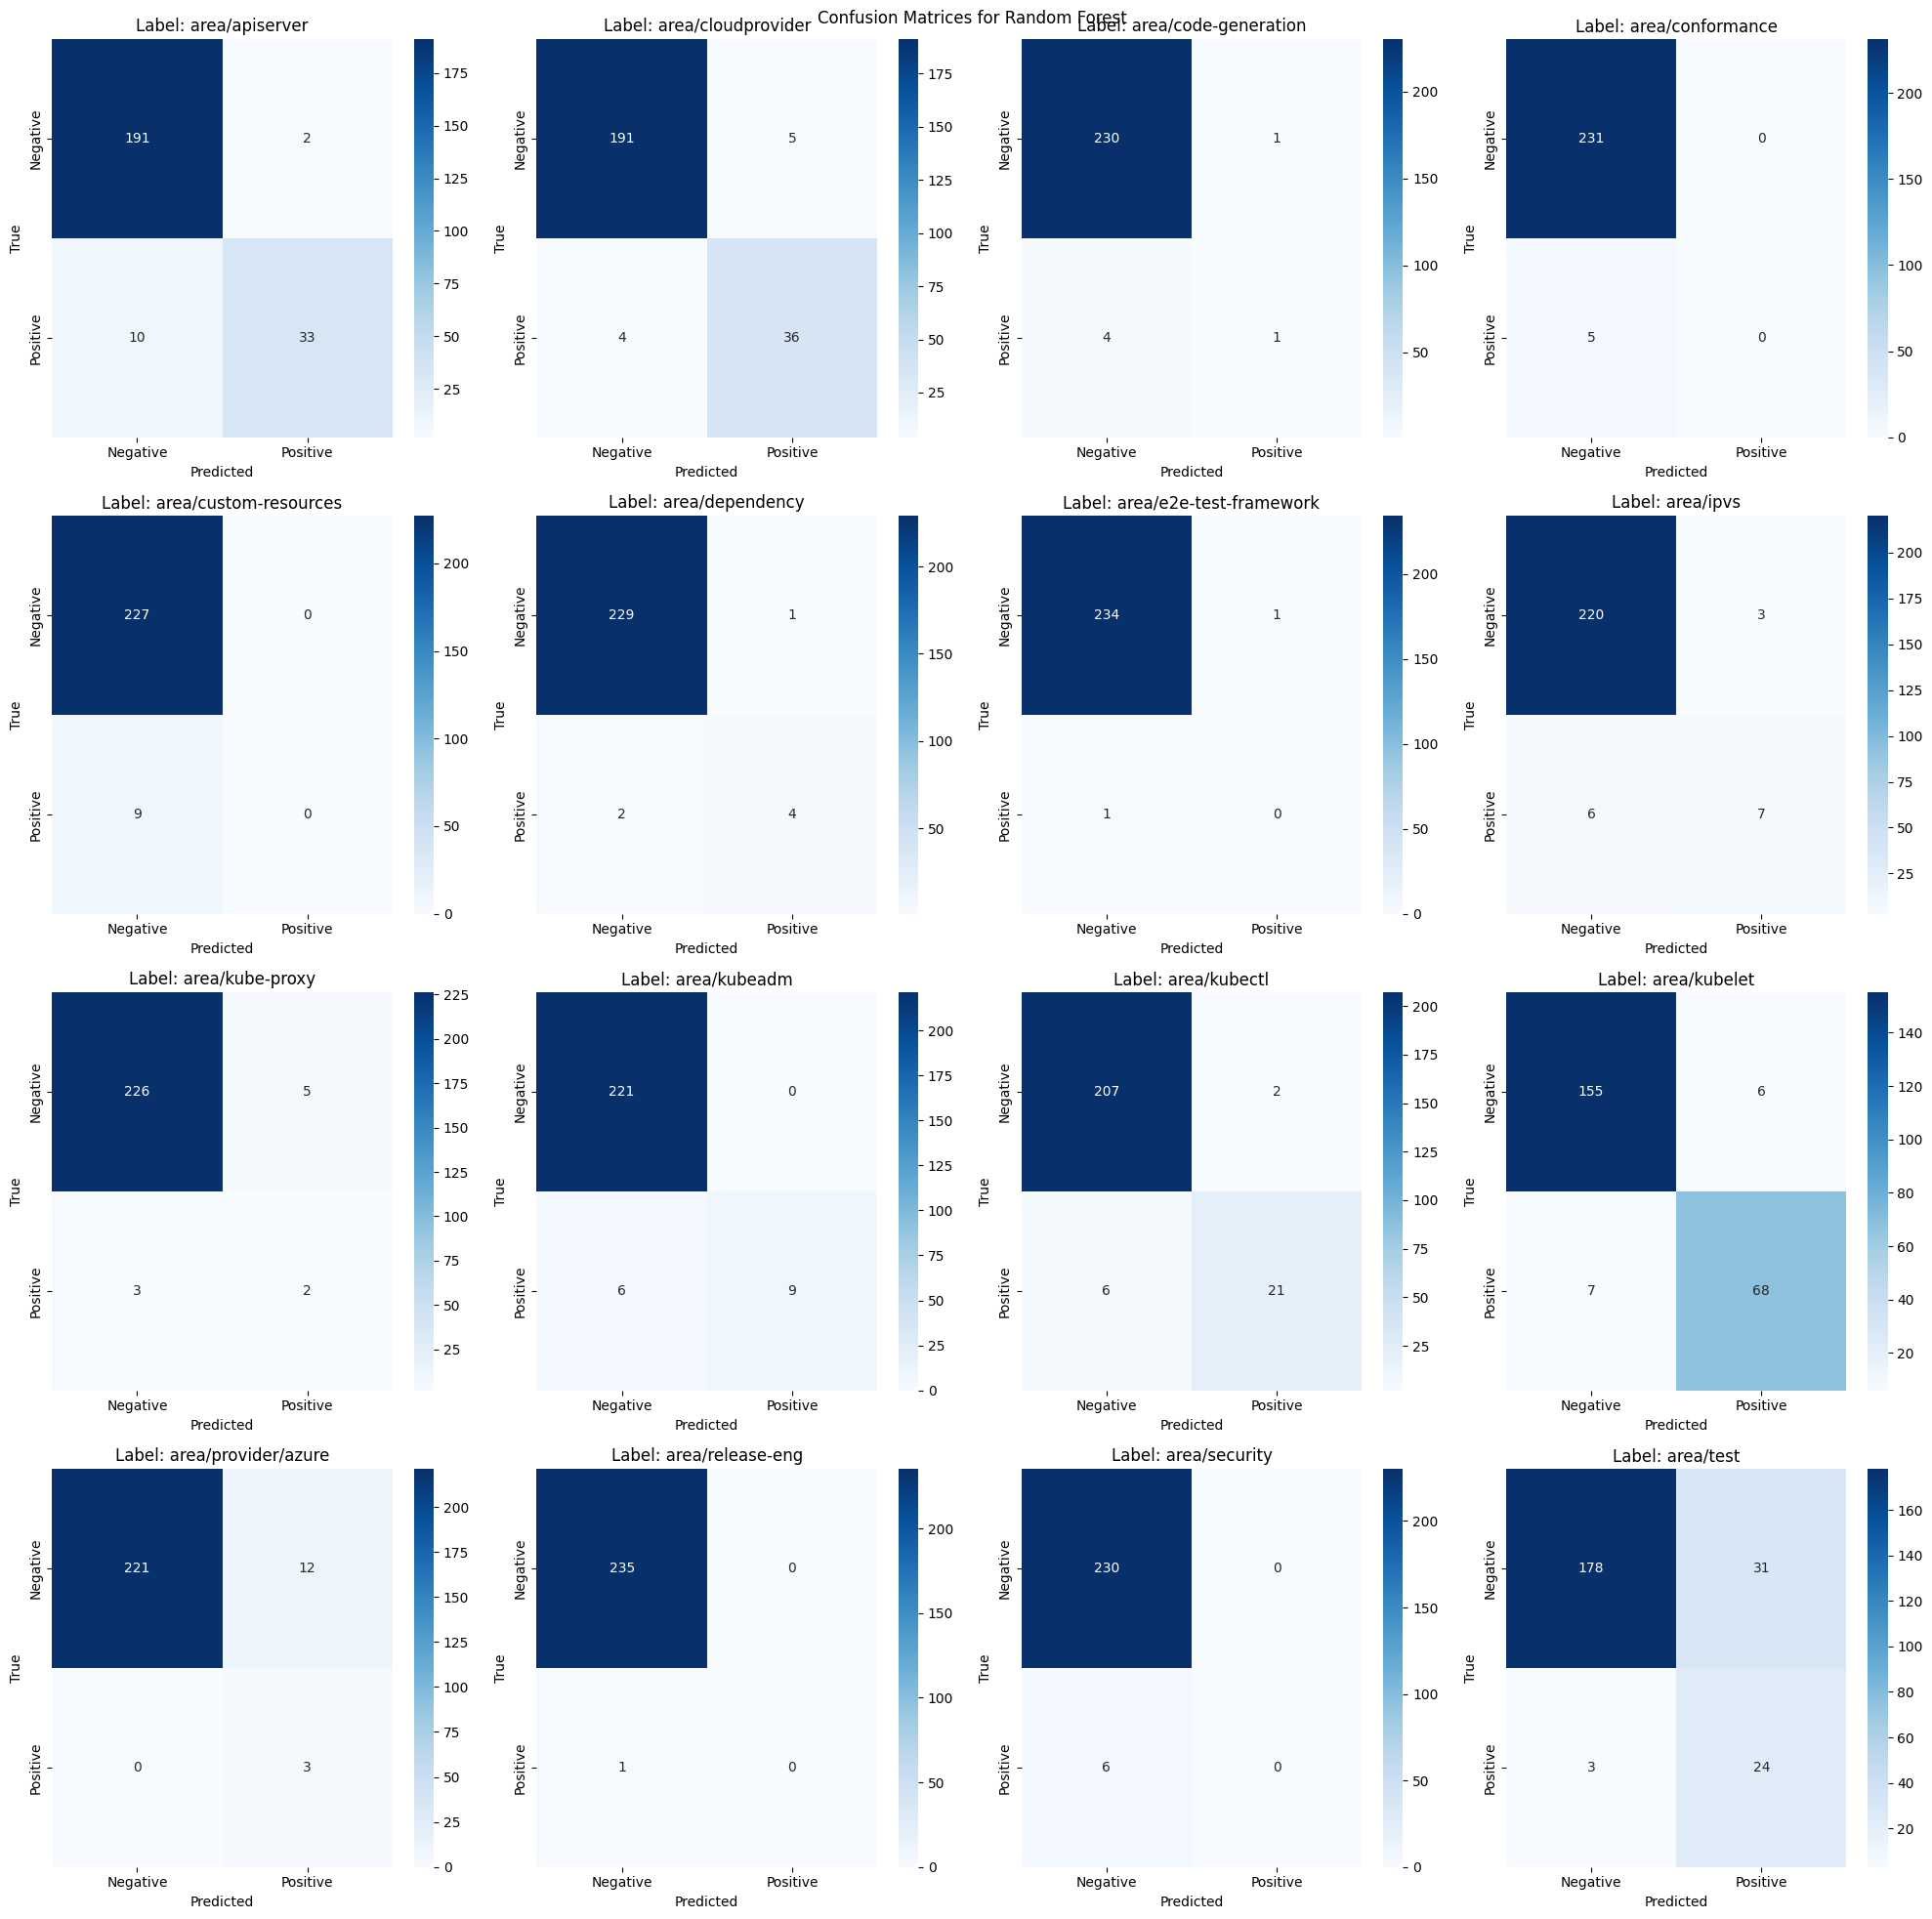

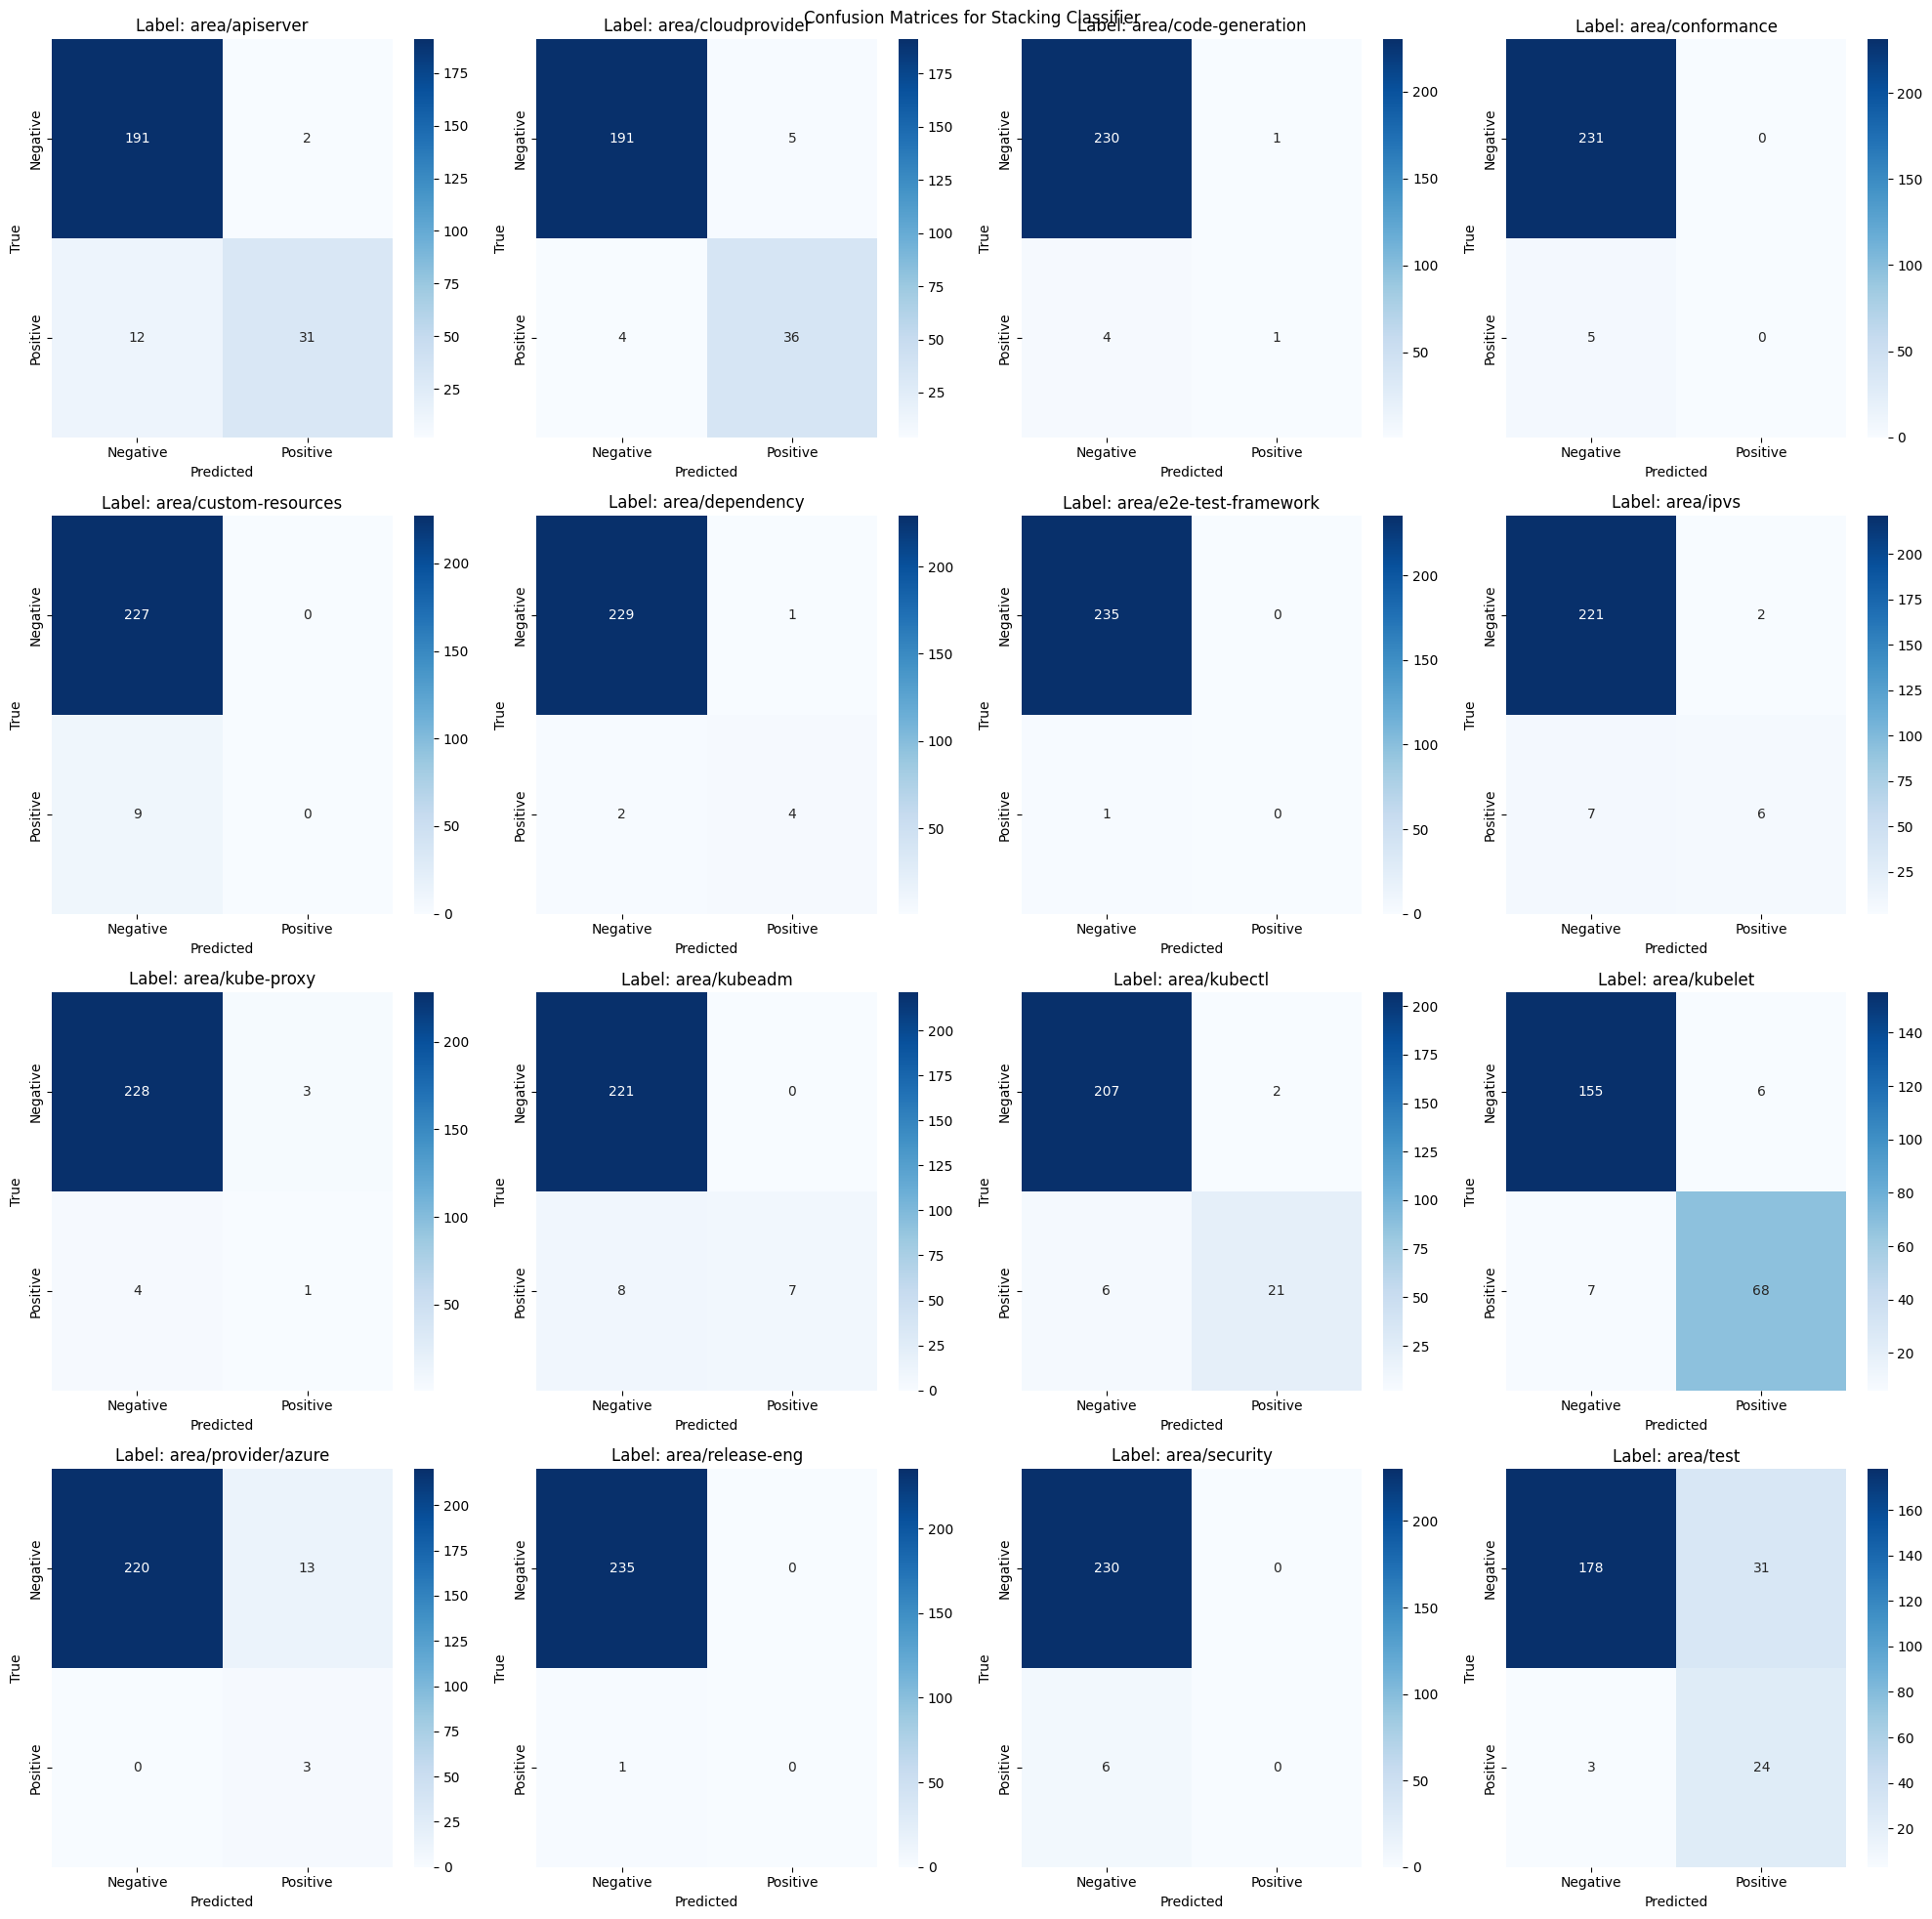

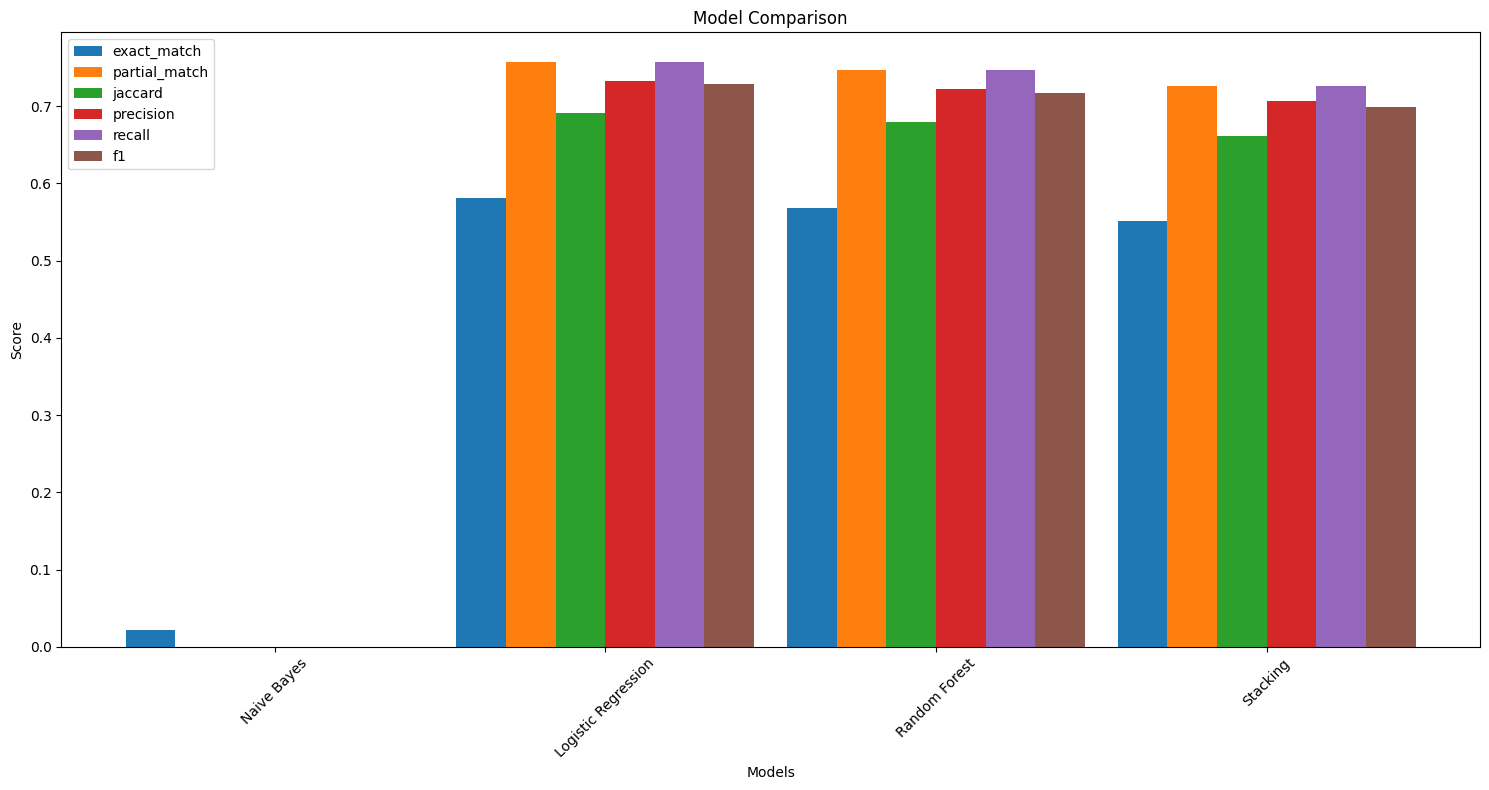

In [124]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Train multiple ML models with SBERT embeddings for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Batch size for generating embeddings')
    parser.add_argument('--training_epochs', type=int, default=20, help='Number of epochs for SBERT fine-tuning (0 to skip)')
    parser.add_argument('--n_estimators', type=int, default=100, help='Number of trees in Random Forest')
    parser.add_argument('--max_depth', type=int, default=None, help='Maximum depth of trees')
    parser.add_argument('--min_samples_split', type=int, default=2, help='Minimum samples required to split')
    parser.add_argument('--min_samples_leaf', type=int, default=1, help='Minimum samples in leaf nodes')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args) 